# The Geography of Fast Food Pricing: Economic Determinants of Menu Prices Across America

**Authors:** Akhil Kambhatla, Mokshda Gangadre, Vyom Agarwal

**Course:** DATA602 - Principles of Data Science

**Date:** December 2025

---

## Table of Contents
1. [Introduction](#introduction)
2. [Data Sources & Collection](#data-sources)
3. [Data Preprocessing & Integration](#preprocessing)
4. [Exploratory Data Analysis](#eda)
5. [Statistical Analysis & Hypothesis Testing](#analysis)
6. [Key Findings & Insights](#insights)
7. [Conclusions & Future Work](#conclusions)
8. [References & Resources](#references)

---

# 1. Introduction

Have you ever wondered whether your favorite fast-food meal costs the same everywhere in America? Walk into any Chipotle in San Francisco's Financial District, and your usual chicken bowl rings up at \$12.95. Meanwhile, your college friend in rural Iowa messages you a photo of his identical bowl priced at $9.50. That's a \$3.45 difference—nearly 27% more—for the exact same product from the same company with the same supply chain. What drives these geographic price differences?

While we often assume that national chain restaurants maintain the same pricing, the reality is much different. Fast-food companies operate in a complex economic landscape where local conditions—median household income, state minimum wage laws, urban versus rural settings, and competitive dynamics—may all influence their pricing strategies.

## Research Question

This tutorial investigates: **What economic and geographic factors systematically influence fast-food menu pricing across the United States?**

Specifically, we examine whether pricing reflects:
1. **Demand-side factors**: Do restaurants charge more in wealthier areas because customers can afford higher prices?
2. **Supply-side factors**: Do higher labor costs (minimum wages) get passed through to consumers?
3. **Business model differences**: Do corporate-owned chains (like Chipotle) price more consistently than franchise-dominated chains (like Domino's and Papa John's)?
4. **Geographic factors**: Do different US regions show systematic pricing variations?



But why do we need this information? Well, understanding fast-food pricing patterns has implications for:
- **Economic Geography**: Revealing how businesses adapt to local purchasing power
- **Consumer Welfare**: Identifying whether low-income communities face regressive pricing
- **Business Strategy**: Comparing centralized versus decentralized pricing models
- **Policy Analysis**: Assessing the real-world effects of minimum wage policies on consumer prices

## Data and Methodology

To answer these questions, we collect and integrate data from multiple sources:
1. **Restaurant Menu Data**: Web-scraped pricing from 6,700+ locations across Chipotle, Domino's, and Papa John's
2. **US Census Data**: Median household income at ZIP code level
3. **Department of Labor Data**: State minimum wage laws
4. **Regional Food Prices**: USDA food retail price indices as control variables

We apply the complete data science lifecycle to this investigation:

**Data Collection** → Scraping restaurant APIs and integrating government datasets

**Data Preprocessing** → Cleaning inconsistent formats, handling missing values, standardizing measurements

**Exploratory Data Analysis** → Visualizing geographic patterns, examining distributions, computing correlations

**Hypothesis Testing** → Statistical tests (ANOVA, regression) to validate economic theories

**Predictive Modeling** → Machine learning models to quantify factor importance and forecast prices

**Insights and Interpretation** → Synthesizing findings to answer our research questions

## What We Will Discover

This analysis will reveal which economic factors matter most for fast-food pricing, how much variance they explain, and whether corporate structure affects pricing consistency. By the end of this tutorial, you will understand not just what drives geographic price variation, but also how to apply rigorous data science methods to real-world economic questions.

## Technical Requirements

This tutorial uses the [Python](https://docs.python.org/3/tutorial/index.html) programming language for its versatility in data science workflows and [Jupyter Notebook](https://jupyter.org/) for interactive development. Specifically, we develop this project in [Google Colaboratory](https://colab.research.google.com/), which provides free cloud-based computing with pre-installed data science libraries. All code in this tutorial is executable in Google Colab. Click the links to learn more about each technology.

Let's begin by collecting our data.


# 2. Data Sources & Collection

This is the first step of the entire project. We had the option of building this project using existing Restaurant APIs, but we wanted to put in the effort of scraping the data from scratch and combining all the data together, resembling a real-world application. We used web-scraping techniques (mentioned in the webscraping section below) to obtain menus and restaurant location details such as latitude, longitude, and zip code for the chains Chipotle, Domino's, and Papa John's. Each restaurant's details are stored in a CSV file.

Apart from these three individual restaurant datasets, we also took the time to see if we could find any other demographic data that would help us answer our main question of the impact of socioeconomic conditions on pricing. Upon searching through the web, we found three datasets that significantly contribute to our research:

1. **[Minimum Wages per State](https://www.dol.gov/agencies/whd/mw-consolidated)**: State-level minimum wage laws from the Department of Labor, which help us test whether labor costs influence menu prices (supply-side hypothesis).

2. **[ZIP Code-Level Income Data](https://data.census.gov/map?q=Income+by+Zip+code+tabulation+area&layer=VT_2023_860_Z2_PY_D1)**: Median household income by ZIP code from the US Census Bureau, allowing us to test whether restaurants charge more in wealthier areas (demand-side hypothesis).


3. **Regional Food Retail Prices**: Regional food price indices from the Bureau of Labor Statistics ([West](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandwest_table.htm), [South](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandsouth_table.htm), [Midwest](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandmidwest_table.htm), [Northeast](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandnortheast_table.htm)), which serve as control variables to account for general cost-of-living differences across regions rather than restaurant-specific pricing strategies.

Each dataset presents unique challenges—from rate-limited APIs during web scraping to inconsistent geographic identifiers that require careful matching across ZIP codes, counties, and states. We will walk through the collection process for each source, explaining the technical approach and data quality considerations.

---

## Setup and Configuration

Before collecting data, we install required libraries and import necessary modules.

### Installations

We install Folium for creating interactive geographic maps to visualize pricing patterns across the United States.

In [ ]:
# !pip install folium
# !pip install folium.plugins
# !pip install statsmodels
# !pip install catboost

### Imports

We import libraries organized by functionality:
- **Web Scraping**: `requests` for API calls, `json` for parsing responses, `time` for rate limiting
- **Data Manipulation**: `pandas` for dataframes, `numpy` for numerical operations
- **Visualization**: `matplotlib` and `seaborn` for static plots, `folium` for interactive maps
- **Statistical Analysis**: `scipy.stats` for hypothesis testing, `statsmodels` for regression
- **Machine Learning**: `sklearn` for preprocessing and modeling

In [ ]:
import requests
import csv
import json
import time
from urllib.parse import urlencode
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

from scipy.stats import f_oneway, pearsonr, ttest_ind
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostRegressor, Pool
from transformers import AutoTokenizer, AutoModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Webscraping

We now collect restaurant menu and location data by scraping the APIs of three major fast-food chains. Each chain exposes different API structures, requiring custom approaches for data extraction. We use Chrome Developer Tools to inspect network requests and identify the API endpoints that power their store locator and menu systems.

Our scraping strategy collects two types of data for each chain:
1. **Store Locations**: Latitude, longitude, address, ZIP code, and store identifiers
2. **Menu Pricing**: Item names, prices, categories, and availability by location

The following subsections detail our scraping methodology for each store as well as scrape the minimum wage info.

### Chipotle

Chipotle operates a corporate-owned model with centralized pricing decisions. Their API structure separates location data from menu data, requiring two separate scraping operations. We first retrieve all restaurant locations nationwide, then query each location's menu individually.

**API Endpoints:**
- **Locations**: `https://services.chipotle.com/restaurant/v3/restaurant`
- **Menus**: `https://services.chipotle.com/menuinnovation/v1/restaurants/{restaurantNumber}/onlinemenu`

**Authentication:** Requires `Ocp-Apim-Subscription-Key` header for API access.

**First Chain Locations**

We begin by fetching all Chipotle store locations using their restaurant search API. The API accepts geographic coordinates and a radius parameter. To capture all US locations, we use a central point (coordinates of Cincinnati, OH) with a radius large enough to cover the entire continental United States (8,000 km).

The API returns paginated results with a maximum of 4,000 stores per page. We extract key fields including restaurant number, address, coordinates, and ZIP code for later matching with demographic data.

*NOTE:* *The webscraping code takes hours to run, because it scrapes 18,00,000 records. So for evaluation, we have also added the csv files for all our data which can directly be used to run the rest of the code successfully.*

In [ ]:
# # chipotle api url
# url = "https://services.chipotle.com/restaurant/v3/restaurant"

# payload_template = {
#     "timestamp": "2020-3-14",
#     "latitude": 39.1031182,
#     "longitude": -84.5120196,
#     "radius": 8000467,
#     "restaurantStatuses": ["OPEN", "LAB"],
#     "conceptIds": ["CMG"],
#     "orderBy": "distance",
#     "orderByDescending": False,
#     "pageSize": 4000,    # <= FIXED
#     "pageIndex": 0,
#     "embeds": {
#         "addressTypes": ["MAIN"],
#         "publicPhoneTypes": ["MAIN PHONE"],
#         "realHours": True,
#         "directions": True,
#         "catering": True,
#         "onlineOrdering": True,
#         "timezone": True,
#         "marketing": True
#     }
# }

# headers = {
#     'Ocp-Apim-Subscription-Key': 'b4d9f36380184a3788857063bce25d6a',
#     'Content-Type': 'application/json',
# }

# all_stores = []

# # Pagination loop
# page = 0
# while True:
#     payload = payload_template.copy()
#     payload["pageIndex"] = page

#     response = requests.post(url, headers=headers, data=json.dumps(payload))
#     stores = response.json()

#     # If API errors, break
#     if "data" not in stores:
#         print("API returned an error:", stores)
#         break

#     data = stores["data"]
#     if not data:
#         break

#     all_stores.extend(data)
#     page += 1

#     print(f"Fetched page {page}, {len(data)} stores")

# print(f"Total stores fetched: {len(all_stores)}")

# # Write CSV
# with open('ChipotleLocations.csv', 'w', newline='') as CSVFile:
#     writer = csv.writer(CSVFile)
#     writer.writerow(["restaurantNumber", "restaurantName", "latitude", "longitude"])

#     for store in all_stores:
#         writer.writerow([
#             store.get("restaurantNumber"),
#             store.get("restaurantName"),
#             store["addresses"][0]["latitude"],
#             store["addresses"][0]["longitude"]
#         ])

**Next, Menu by Locations**

With all store locations collected, we now scrape individual menus for each restaurant. Chipotle's menu API requires the restaurant number as a path parameter. For each of the 3,800+ locations, we query the online menu endpoint and extract item names, prices, and categories.

We implement rate limiting (0.1 second delay between requests) to avoid overwhelming the API server. Menu items are deduplicated by item code, as some items appear multiple times with different customization options.

In [ ]:
# RESTAURANT_URL = "https://services.chipotle.com/restaurant/v3/restaurant"
# MENU_URL_TEMPLATE = (
#     "https://services.chipotle.com/menuinnovation/v1/restaurants/"
#     "{restaurant_id}/onlinemenu?channelId=web&includeUnavailableItems=true"
# )

# COMMON_HEADERS = {
#     'Accept': 'application/json, text/plain, */*',
#     'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
#                   'AppleWebKit/537.36 (KHTML, like Gecko) '
#                   'Chrome/80.0.3987.132 Safari/537.36',
#     'Origin': 'https://www.chipotle.com',
#     'Referer': 'https://www.chipotle.com/',
#     'Accept-Language': 'en-US,en;q=0.9,la;q=0.8,pt;q=0.7',
#     'Ocp-Apim-Subscription-Key': 'b4d9f36380184a3788857063bce25d6a',
# }

# RESTAURANT_HEADERS = {
#     **COMMON_HEADERS,
#     'Content-Type': 'application/json',
# }

# MENU_HEADERS = {
#     **COMMON_HEADERS
# }

# # menu item scraping function

# def extract_menu_items(menu_json):
#     """
#     Recursively walk the menu JSON and return a list of
#     (item_name, unit_price) tuples for any object that has
#     an itemName and unitPrice field.
#     """
#     items = []

#     def walk(obj):
#         if isinstance(obj, dict):
#             if "itemName" in obj and "unitPrice" in obj:
#                 name = obj.get("itemName")

#                 price_raw = obj.get("unitPrice")
#                 price = None

#                 if isinstance(price_raw, (int, float, str)):
#                     price = price_raw
#                 elif isinstance(price_raw, dict):
#                     price = (
#                         price_raw.get("amount")
#                         or price_raw.get("price")
#                         or price_raw.get("value")
#                     )

#                 items.append((name, price))
#             for v in obj.values():
#                 walk(v)

#         elif isinstance(obj, list):
#             for v in obj:
#                 walk(v)

#     walk(menu_json)
#     return items

# def fetch_all_restaurants():
#     page_index = 0
#     page_size = 4000
#     all_restaurants = []

#     while True:
#         payload = {
#             "timestamp": "2020-3-14",
#             "latitude": 39.1031182,
#             "longitude": -84.5120196,
#             "radius": 8000467,
#             "restaurantStatuses": ["OPEN", "LAB"],
#             "conceptIds": ["CMG"],
#             "orderBy": "distance",
#             "orderByDescending": False,
#             "pageSize": page_size,
#             "pageIndex": page_index,
#             "embeds": {
#                 "addressTypes": ["MAIN"],
#                 "publicPhoneTypes": ["MAIN PHONE"],
#                 "realHours": True,
#                 "directions": True,
#                 "catering": True,
#                 "onlineOrdering": True,
#                 "timezone": True,
#                 "marketing": True
#             }
#         }

#         resp = requests.post(
#             RESTAURANT_URL,
#             headers=RESTAURANT_HEADERS,
#             data=json.dumps(payload)
#         )
#         data = resp.json()

#         if "data" not in data:
#             print("Restaurant API error on page", page_index, "->", data)
#             break

#         restaurants = data["data"]
#         if not restaurants:
#             break

#         all_restaurants.extend(restaurants)
#         print(f"Fetched restaurant page {page_index}, {len(restaurants)} records")

#         page_index += 1
#         time.sleep(0.2)

#     print(f"Total restaurants fetched: {len(all_restaurants)}")
#     return all_restaurants

# # for each restaurant here, we fetch menu and write it to csv

# def get_chipotle():
#     restaurants = fetch_all_restaurants()

#     with open("ChipotleMenuByLocation.csv", mode="w", newline="", encoding="utf-8") as f:
#         writer = csv.writer(f)
#         writer.writerow(["city", "state", "pincode", "menu_item", "price"])

#         for idx, store in enumerate(restaurants, start=1):
#             addr = (store.get("addresses") or [{}])[0]
#             city = addr.get("locality")
#             state = addr.get("administrativeArea")
#             pincode = addr.get("postalCode")

#             restaurant_number = store.get("restaurantNumber")

#             if not restaurant_number:
#                 print("Skipping store with no restaurantNumber:", store)
#                 continue

#             menu_url = MENU_URL_TEMPLATE.format(restaurant_id=restaurant_number)

#             try:
#                 menu_resp = requests.get(menu_url, headers=MENU_HEADERS)
#                 if menu_resp.status_code != 200:
#                     print(
#                         f"[{idx}/{len(restaurants)}] "
#                         f"Menu API error {menu_resp.status_code} for {restaurant_number}"
#                     )
#                     continue

#                 menu_json = menu_resp.json()
#             except Exception as e:
#                 print(f"Error fetching menu for {restaurant_number}: {e}")
#                 continue

#             menu_items = extract_menu_items(menu_json)

#             if not menu_items:
#                 print(f"[{idx}/{len(restaurants)}] No menu items found for {restaurant_number}")
#                 continue

#             print(
#                 f"[{idx}/{len(restaurants)}] {city}, {state} ({pincode}) "
#                 f"- {len(menu_items)} items"
#             )

#             for item_name, price in menu_items:
#                 writer.writerow([city, state, pincode, item_name, price])
#             time.sleep(0.1)

# get_chipotle()


### Domino's

Domino's operates primarily through a franchise model, where individual franchisees have more autonomy over local pricing decisions. Unlike Chipotle's two-step process, Domino's allows us to query stores by ZIP code and retrieve menu data in a single API call per store.

**API Endpoints:**
- **Store Locator**: `https://order.dominos.com/power/store-locator` (accepts ZIP code parameter)
- **Menu**: `https://order.dominos.com/power/store/{store_id}/menu?lang=en&structured=true`

**Approach:** We iterate through all [US ZIP codes](https://postalpro.usps.com/ZIP_Locale_Detail), find stores in each ZIP, then scrape their menus. This ZIP-based approach naturally aligns with our demographic data integration strategy.

**Note:** We are using an existing list of zip codes across the entire US as reference to get menus of all the valid locations(matched ones). This is done for both - Domino's and Papa John's.

**Menu By Locations**

For each ZIP code, we query Domino's store locator API to find nearby restaurants. The API returns store IDs, addresses, and coordinates. We then fetch each store's menu using the store-specific menu endpoint.

**Key Implementation Details:**
- **ZIP Code Coverage**: We query all ~42,000 US ZIP codes to ensure complete national coverage
- **Rate Limiting**: 0.05 second delay between menu requests (faster than Chipotle due to simpler API)
- **Error Handling**: We implement timeout protection (10 seconds) and skip stores that fail to respond
- **Progress Tracking**: Status printed every 50 stores to monitor scraping progress

The output CSV contains store location (city, state, ZIP), menu item names, and prices for approximately 6,500 Domino's locations nationwide.

In [ ]:
# # US ZIP CODE LINK TO DRIVE
# zip_url = "https://drive.google.com/file/d/1IDG4kjx1-7DkDj-mXy6H_rv9H_lR3Mix/view?usp=share_link"
# zip_url='https://drive.google.com/uc?id=' + zip_url.split('/')[-2]
# df = pd.read_csv(zip_url)

# zip_list = df["ZIP CODE"].astype(str).str.zfill(5).unique().tolist()

# ZIP_CODES = zip_list

# STORE_LOCATOR_URL = "https://order.dominos.com/power/store-locator"
# MENU_URL_TEMPLATE = (
#     "https://order.dominos.com/power/store/{store_id}/menu?lang=en&structured=true"
# )

# COMMON_HEADERS = {
#     "Accept": "application/json, text/plain, */*",
#     "User-Agent": "Mozilla/5.0",
# }


# def extract_menu_items(menu_json):
#     items = []
#     seen = set()

#     def get_name_and_price(obj):
#         name = (
#             obj.get("Name") or obj.get("name") or
#             obj.get("ProductName") or obj.get("productName")
#         )
#         price_raw = (
#             obj.get("Price") or obj.get("price") or
#             obj.get("Amount") or obj.get("amount")
#         )

#         if name is None or price_raw is None:
#             return None, None

#         price = price_raw
#         if isinstance(price_raw, dict):
#             price = (
#                 price_raw.get("Amount") or price_raw.get("amount") or
#                 price_raw.get("Price") or price_raw.get("price")
#             )

#         return name, price

#     def walk(obj):
#         if isinstance(obj, dict):
#             name, price = get_name_and_price(obj)
#             if name and price:
#                 key = (str(name), str(price))
#                 if key not in seen:
#                     seen.add(key)
#                     items.append((name, price))
#             for v in obj.values():
#                 walk(v)

#         elif isinstance(obj, list):
#             for v in obj:
#                 walk(v)

#     walk(menu_json)
#     return items

# # FETCH STORES FOR GIVEN ZIP

# def fetch_stores_for_zip(zip_code):
#     params = {"s": "", "c": zip_code, "type": "Delivery"}
#     url = f"{STORE_LOCATOR_URL}?{urlencode(params)}"

#     try:
#         resp = requests.get(url, headers=COMMON_HEADERS, timeout=10)
#         data = resp.json()
#     except:
#         return []

#     stores = data.get("Stores") or []
#     return stores


# # MAIN SCRAPER

# def get_dominos():
#     all_stores = {}  # StoreID → store object

#     print("Collecting all Domino's stores across the USA...")
#     for i, z in enumerate(ZIP_CODES):
#         stores = fetch_stores_for_zip(z)

#         for s in stores:
#             store_id = (
#                 s.get("StoreID") or s.get("StoreId") or
#                 s.get("storeID") or s.get("id")
#             )
#             if not store_id:
#                 continue
#             if store_id not in all_stores:
#                 all_stores[store_id] = s

#         if i % 200 == 0:
#             print(f"Processed {i} ZIPs, total unique stores so far: {len(all_stores)}")

#         time.sleep(0.05)

#     print(f"\nTotal Unique Domino's Stores Found: {len(all_stores)}")
#     print("Fetching menus...")

#     with open("Dominos_ALL_USA.csv", "w", newline="", encoding="utf-8") as f:
#         writer = csv.writer(f)
#         writer.writerow(["city", "state", "zip", "menu_item", "price"])

#         for idx, (store_id, store) in enumerate(all_stores.items(), start=1):

#             addr = store.get("Address") or store.get("StoreAddress") or {}

#             city = (
#                 store.get("City") or store.get("city") or
#                 addr.get("City") or addr.get("city")
#             )
#             state = (
#                 store.get("Region") or store.get("region") or
#                 addr.get("Region") or addr.get("region")
#             )
#             postal = (
#                 store.get("PostalCode") or store.get("postalCode") or
#                 addr.get("PostalCode") or addr.get("postalCode")
#             )

#             menu_url = MENU_URL_TEMPLATE.format(store_id=store_id)

#             try:
#                 menu_resp = requests.get(menu_url, headers=COMMON_HEADERS, timeout=10)
#                 menu_json = menu_resp.json()
#             except:
#                 continue

#             menu_items = extract_menu_items(menu_json)

#             for name, price in menu_items:
#                 writer.writerow([city, state, postal, name, price])

#             if idx % 50 == 0:
#                 print(f"Store {idx}/{len(all_stores)} complete")

#             time.sleep(0.05)

#     print("\n Completed USA Domino’s scrape! File saved as Dominos_ALL_USA.csv")

# get_dominos()

### Papa John's

Papa John's, like Domino's, operates through a franchise model. Their API structure is similar to Domino's, allowing ZIP-based store lookup followed by individual store menu queries.

**API Endpoints:**
- **Store Search**: `https://www.papajohns.com/order/storesSearchJson` (accepts ZIP code parameter)
- **Menu Products**: `https://www.papajohns.com/api/v6/stores/{store_id}/products`

**Approach:** We use the same ZIP code iteration strategy as Domino's. For each ZIP, we find nearby stores, then fetch their product catalogs. The implementation includes longer timeout periods (15 seconds) compared to Domino's, as Papa John's API tends to have slower response times.

**Technical Notes:**
- **Rate Limiting**: 0.1 second delay between requests (moderate throttling)
- **Timeout Protection**: 15 second timeout (longer than Domino's due to API performance)
- **Session Management**: Uses `requests.Session()` to maintain connection pooling for efficiency

In [ ]:
# # US ZIP CODE URL LINK
# zip_url = "https://drive.google.com/file/d/1IDG4kjx1-7DkDj-mXy6H_rv9H_lR3Mix/view?usp=share_link"
# zip_url='https://drive.google.com/uc?id=' + zip_url.split('/')[-2]
# zip_df = pd.read_csv(zip_url)

# zip_series = zip_df["ZIP CODE"].dropna()

# zip_codes = (
#     zip_series
#     .astype(int)
#     .astype(str)
#     .str.zfill(5)
#     .unique()
#     .tolist()
# )

# print(f"Total unique ZIPs loaded: {len(zip_codes)}")

# # API configs
# STORE_SEARCH_URL = "https://www.papajohns.com/order/storesSearchJson"
# PRODUCTS_URL_TEMPLATE = "https://www.papajohns.com/api/v6/stores/{store_id}/products"

# session = requests.Session()
# session.headers.update({
#     "User-Agent": "Mozilla/5.0 (compatible; PapaScraper/1.0; +https://example.com)"
# })

# # Fetch stores for each ZIP
# stores_data = []
# seen_store_ids = set()

# for z in tqdm(zip_codes, desc="Fetching stores by ZIP"):
#     params = {
#         "searchType": "CARRYOUT",
#         "zipcode": z
#     }
#     try:
#         resp = session.get(STORE_SEARCH_URL, params=params, timeout=15)
#         if resp.status_code != 200:
#             print(f"[WARN] ZIP {z}: status {resp.status_code}")
#             continue
#         data = resp.json()
#     except Exception as e:
#         print(f"[ERROR] ZIP {z}: {e}")
#         continue

#     for store in data.get("stores", []):
#         store_id = store.get("storeId")
#         if store_id is None or store_id in seen_store_ids:
#             continue

#         seen_store_ids.add(store_id)
#         loc = store.get("storeLocation", {}) or {}

#         stores_data.append({
#             "restaurant_id": store_id,
#             "city": loc.get("city"),
#             "state": loc.get("state"),
#             "pincode": loc.get("postalCode"),
#             "latitude": loc.get("latitude"),
#             "longitude": loc.get("longitude"),
#             "restaurant_name": store.get("storeName", "Papa Johns")
#         })

#     time.sleep(0.1)

# stores_df = pd.DataFrame(stores_data)
# print(f"Total unique stores found: {len(stores_df)}")


# # Fetch menu items for each store
# menu_rows = []

# for idx, store_row in tqdm(stores_df.iterrows(), total=len(stores_df), desc="Fetching products by store"):
#     store_id = store_row["restaurant_id"]
#     url = PRODUCTS_URL_TEMPLATE.format(store_id=store_id)

#     try:
#         resp = session.get(url, timeout=15)
#         if resp.status_code != 200:
#             print(f"[WARN] Store {store_id}: status {resp.status_code}")
#             continue
#         data = resp.json()
#     except Exception as e:
#         print(f"[ERROR] Store {store_id}: {e}")
#         continue

#     products = data.get("data", [])
#     for p in products:
#         menu_item = p.get("name") or p.get("title")
#         price = p.get("displayPrice") or p.get("regularMenuPrice")
#         menu_type = p.get("tag") or p.get("productTypeId")

#         menu_rows.append({
#             "restaurant_id": store_row["restaurant_id"],
#             "city": store_row["city"],
#             "state": store_row["state"],
#             "pincode": store_row["pincode"],
#             "latitude": store_row["latitude"],
#             "longitude": store_row["longitude"],
#             "restaurant_name": store_row["restaurant_name"],
#             "menu_item": menu_item,
#             "price": price,
#             "menu_type": menu_type
#         })

#     time.sleep(0.1)

# menu_df = pd.DataFrame(menu_rows)
# menu_df.drop_duplicates(
#     subset=["restaurant_id", "menu_item", "price"],
#     inplace=True
# )

# print(f"Total menu rows: {len(menu_df)}")
# OUTPUT_CSV = "papajohns_menu_USA.csv"
# menu_df.to_csv(OUTPUT_CSV, index=False)
# print(f"Saved to: {OUTPUT_CSV}")

### Minimum Wage Data

Our final web scraping target is the Department of Labor's minimum wage table. Unlike restaurant APIs, this data is published as an HTML table on a government website. We use pandas' `read_html()` function to parse the table directly from the webpage.

**Data Source:** [DOL Minimum Wage Consolidated Table](https://www.dol.gov/agencies/whd/mw-consolidated)

**Challenge:** The table has an unusual format with three columns:
1. States with minimum wage above federal level (e.g., "CA \$16.50")
2. States at federal minimum (\$7.25)
3. States with minimum below federal (but federal applies)

We parse each column differently, extracting state codes and wage values, then standardize to a simple state-wage mapping. States with "or" cases (multiple rates) use the highest rate.

In [ ]:
# MINIMUM WAGE

def get_min_wage_data():

    url = "https://www.dol.gov/agencies/whd/mw-consolidated"
    dfs = pd.read_html(url)
    wage_table = dfs[0]

    states_wages = []

    # Process all three columns
    for col_idx in range(min(3, len(wage_table.columns))):
        col_data = wage_table.iloc[:, col_idx].dropna()

        for entry in col_data:
            entry_str = str(entry).strip()

            # Column 1: States with wages > $7.25 (format: "AK $11.91" or "NY $16.50 or $15.50")
            if '$' in entry_str:
                # Handle "or" cases - take first (highest) wage
                if ' or ' in entry_str:
                    entry_str = entry_str.split(' or ')[0].strip()

                parts = entry_str.split('$')
                if len(parts) == 2:
                    state = parts[0].strip()
                    wage_str = parts[1].strip()

                    # Clean wage (remove footnotes)
                    wage_clean = ''.join(c for c in wage_str if c.isdigit() or c == '.')

                    try:
                        wage = float(wage_clean)
                        if len(state) == 2 and state.isalpha():
                            states_wages.append({'state': state.upper(), 'min_wage': wage})
                    except:
                        continue

            # Columns 2 & 3: States at/below federal minimum ($7.25)
            elif len(entry_str) == 2 and entry_str.isalpha():
                states_wages.append({'state': entry_str.upper(), 'min_wage': 7.25})

    # Create DataFrame and remove duplicates
    wage_df = pd.DataFrame(states_wages).drop_duplicates('state', keep='first')
    wage_df['min_wage'] = pd.to_numeric(wage_df['min_wage'], errors='coerce')

    # Sort by wage descending
    wage_df = wage_df.sort_values('min_wage', ascending=False).reset_index(drop=True)

    return wage_df


# Execute
wage_df = get_min_wage_data()

# Verify
print(f"Sample (top 10 states by wage):")
print(wage_df.head(100)[['state', 'min_wage']].to_string(index=False))

Sample (top 10 states by wage):
state  min_wage
   DC    17.500
   WA    16.660
   NY    16.500
   CA    16.500
   CT    16.350
   OR    15.950
   NJ    15.490
   MD    15.000
   DE    15.000
   MA    15.000
   RI    15.000
   IL    15.000
   CO    14.810
   AZ    14.700
   ME    14.650
   VT    14.010
   HI    14.000
   MO    13.750
   NE    13.500
   FL    13.000
   VA    12.410
   NM    12.000
   NV    12.000
   AK    11.910
   SD    11.500
   MN    11.130
   AR    11.000
   OH    10.700
   MI    10.563
   MT    10.550
   PR    10.500
   VI    10.500
   GU     9.250
   WV     8.750
   IA     7.250
   ID     7.250
   IN     7.250
   KS     7.250
   KY     7.250
   NC     7.250
   ND     7.250
   NH     7.250
   OK     7.250
   PA     7.250
   TX     7.250
   UT     7.250
   WI     7.250
   AL     7.250
   GA     7.250
   LA     7.250
   MS     7.250
   SC     7.250
   TN     7.250
   WY     7.250


## External Data Sources

In addition to the restaurant and minimum wage data we scraped, we integrate two publicly available datasets from government sources. These provide the more context needed to test our hypotheses about pricing determinants.

**Note on Data Access:** The code below shows our file paths from Google Drive. You can either:
1. Follow the same Google Drive structure, add the files to your Drive, and mount your drive, or
2. Download these datasets from our [GitHub repository](LINK_TO_YOUR_REPO) and modify the file paths to your local directory

All datasets are also available directly from the official government sources linked below.

### ZIP Code-Level Income Data

We use median household income at the ZIP code level to test our demand-side pricing hypothesis: do restaurants charge more in wealthier areas because customers can afford higher prices?

**Data Source:** [US Census Bureau - Income by ZIP Code Tabulation Area](https://data.census.gov/map?q=Income+by+Zip+code+tabulation+area&layer=VT_2023_860_Z2_PY_D1)

**Geographic Granularity:** ZIP code level (5-digit ZIP codes) provides the finest available geographic resolution for income data, allowing precise matching with restaurant locations.

**Key Variable:** Median household income (in dollars) represents the typical household's purchasing power in each ZIP code area.

**Data Format:** The Census Bureau provides this data through tables (click on [Download Table Data](https://data.census.gov/table?q=Income+by+Zip+code+tabulation+area)). We downloaded this data in .xlsx format, cleaned the dataset to have only 2 features - Zip code and Income, and exported this file as a comma separated file (.csv).

We load this dataset and rename the ZIP code column to match our restaurant data format for easier integration during the preprocessing phase.

In [ ]:
income_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/zip_income_data.csv", dtype={"zip": str})
income_df = income_df.rename(columns = {"zip":"pincode"})

### USDA Rural-Urban Continuum Codes
**NOTE: WE ARE NOT USING THIS DATASET. THIS IS ONLY FOR EXTENDED KNOWLEDGE PURPOSES ONLY**

The USDA Economic Research Service publishes county-level classification codes that measure urbanization on a scale from 1 to 9:
- **1-3**: Metropolitan counties (large to small metros with 250,000+ population)
- **4-6**: Urban non-metropolitan counties (with towns 2,500-19,999 residents)
- **7-9**: Rural counties (no town over 2,500 residents)

**Data Source:** [USDA ERS Rural-Urban Continuum Codes 2023](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes)

**Why This Matters:** Urbanization affects restaurant operating costs (commercial rent, labor markets) and competitive dynamics. Rural areas may have less competition, potentially leading to market power and higher prices despite lower local incomes. This variable allows us to test whether geographic isolation affects pricing strategies.

**Format:** County-level FIPS codes (Federal Information Processing Standards) matched to rural-urban classification. We downloaded this directly as a CSV file from the USDA website.

We load the CSV and extract the 2023 classification codes, then process them to enable matching with restaurant ZIP codes through county-level geographic identifiers.



In [ ]:
# USDA RURAL CODES

def get_usda_rural_data():

    usda_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/Ruralurbancontinuumcodes2023.csv", encoding='latin1')

    usda_rucc = usda_df[usda_df['Attribute'] == 'RUCC_2023'].copy()

    usda_rucc.rename(columns={
        'Value': 'rural_code',
        'County_Name': 'county_name'
    }, inplace=True)
    usda_rucc['FIPS'] = usda_rucc['FIPS'].astype(str).str.zfill(5)

    usda_rucc['rural_code'] = pd.to_numeric(usda_rucc['rural_code'], errors='coerce')

    usda_rucc = usda_rucc[['FIPS', 'State', 'county_name', 'rural_code']].copy()

    return usda_rucc


usda_df = get_usda_rural_data()

print(f"\n Sample:")
print(usda_df.head(10).to_string(index=False))


 Sample:
 FIPS State     county_name  rural_code
01001    AL  Autauga County           2
01003    AL  Baldwin County           3
01005    AL  Barbour County           6
01007    AL     Bibb County           1
01009    AL   Blount County           1
01011    AL  Bullock County           8
01013    AL   Butler County           6
01015    AL  Calhoun County           3
01017    AL Chambers County           6
01019    AL Cherokee County           8


### Regional Food Retail Prices

To control for general cost-of-living differences across regions, we include regional food price indices from the Bureau of Labor Statistics. These indices capture the baseline cost of food retail items (groceries, milk, bread, meat, etc.) in four major US Census regions.

**Data Sources:** Bureau of Labor Statistics - Average Retail Food Prices by Region
- [West Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandwest_table.htm)
- [South Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandsouth_table.htm)
- [Midwest Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandmidwest_table.htm)
- [Northeast Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandnortheast_table.htm)

**Why This Matters:** Fast-food prices may be higher in certain regions simply because all food costs more there, not because of restaurant-specific pricing strategies. By including regional food prices as a control variable, we can separate general cost-of-living effects from pricing differences based on local income levels.

We will be using this in the ML phase.




# 3. Data Preprocessing

After collecting raw data from multiple sources, we now face the challenge of transforming these different datasets into an analysis-ready format. This preprocessing phase addresses several critical data quality issues:

1. **Inconsistent Formats**: Restaurant data uses different column names and data types
2. **Missing Values**: Not all stores have complete ZIP code or location information  
3. **Invalid Entries**: Some scraped data includes non-US locations or placeholder values
4. **Geographic Mismatches**: Restaurant ZIP codes must be matched to county-level rural codes
5. **Menu Item Comparability**: We need to filter for equivalent meal types across chains

Our preprocessing workflow follows these steps:

**State Validation** → Filter to valid US states and territories (51 total including DC)

**Individual Brand Cleaning** → Process each restaurant chain separately to handle brand-specific data structures

**Data Integration** → Merge restaurant data with demographic variables (income, minimum wage, rural codes)

**Missing Value Imputation** → Handle incomplete data using geographic nearest-neighbor approaches

**Data Type Standardization** → Ensure numeric columns are properly formatted

**Final Quality Checks** → Remove remaining invalid entries and verify data completeness

This section documents each preprocessing step with explanations and how they prepare the data.


## State Validation

Before processing restaurant data, we define a reference list of valid US states and territories. This list serves as a filter to remove any non-US entries that may have been captured during web scraping (e.g., Canadian or international locations that appeared in API responses).

Our validation includes all 50 US states plus the District of Columbia (DC), for a total of 51 valid geographic entities. We will apply this filter to each restaurant dataset.

In [ ]:
valid_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC']

## Brand-Specific Cleaning: Chipotle

We begin by processing Chipotle's data, which was collected in two separate files during the scraping phase:
1. **ChipotleMenuByLocation.csv** - Contains menu items and prices per restaurant
2. **ChipotleLocations.csv** - Contains restaurant metadata (coordinates, addresses)

These files must be merged to create a complete dataset with both menu information and geographic location for each restaurant.

**Cleaning Steps:**
1. Load menu data file
2. Load location data and merge on restaurant ID
3. Remove zero-price items (free sides, customization options)
4. Filter to valid US states only

This process reduces the raw dataset from approximately 5.89M rows to 1.48M validated menu items.

### Load Menu Data

We first load the menu-by-location file containing pricing information for each Chipotle restaurant.

In [ ]:
chipotle_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/ChipotleMenuByLocation.csv")
chipotle_df.head()

,restaurant_id,city,state,pincode,menu_item,price
0,1222,Cincinnati,OH,45202-3119,Chicken Kids Build Your Own,5.6
1,1222,Cincinnati,OH,45202-3119,Kid's Fruit,0.0
2,1222,Cincinnati,OH,45202-3119,Kid's Chips,0.0
3,1222,Cincinnati,OH,45202-3119,No Included Sides,0.0
4,1222,Cincinnati,OH,45202-3119,Black Beans,0.0


### Merge with Location Data

We now load the restaurant locations file and merge it with menu data using restaurant ID as the key. This two-file structure resulted from our scraping approach: Chipotle's API provides separate endpoints for location lookup and menu retrieval.

After merging, we drop duplicate columns and add a standardized restaurant_name identifier for consistency across all three chains.

In [ ]:
chipotle_df_2 = pd.read_csv("/content/drive/MyDrive/602_project/Data/ChipotleLocations.csv")
chipotle_merged_df = pd.merge(chipotle_df, chipotle_df_2, left_on="restaurant_id", right_on="restaurantNumber")
chipotle_merged_df.drop(columns=['restaurantNumber','restaurantName'], inplace=True)
chipotle_merged_df["restaurant_name"] = "chipotle"

### Data Quality Filtering

We apply two filters:

1. **Remove zero-price items**: Chipotle's menu includes free customization options (extra rice, beans) and included sides with $0.00 prices. These aren't purchasable items, so we exclude them.

2. **State validation**: Filter to valid US states only, removing any international locations captured during scraping.

The print statements show progressive data reduction, verifying each filter's impact.

In [ ]:
print(len(chipotle_merged_df))
chipotle_merged_df = chipotle_merged_df[chipotle_merged_df['price']>0]
print(len(chipotle_merged_df))
chipotle_merged_df = chipotle_merged_df[chipotle_merged_df['state'].isin(valid_states)]
print(len(chipotle_merged_df))

5892857
1503104
1475810


## Brand-Specific Cleaning: Domino's

Unlike Chipotle's two-file structure, Domino's data was collected in a single CSV file (Dominos_ALL_USA.csv). However, Domino's presents a different challenge: their franchise model means menu item naming varies by location, and the dataset includes combo deals that must be filtered out for fair comparison.

**Cleaning Steps:**
1. Load CSV and standardize column names
2. Categorize menu items (mains, sides, drinks)
3. Exclude combo deals and bundles
4. Remove non-food items
5. Filter zero-price items and validate states


### Load and Standardize

We load Domino's data and immediately standardize column names to match Chipotle's structure, ensuring consistency for later merging.

In [ ]:
dominoes_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/Dominos_ALL_USA.csv")
dominoes_df["restaurant_name"] = "dominoes"
dominoes_df = dominoes_df.rename(columns = {"zip":"pincode","menu_type":"item_type"})
print(len(dominoes_df))

/tmp/ipython-input-540585379.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dominoes_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/Dominos_ALL_USA.csv")


953574


### Menu Item Categorization

Domino's menu contains a wide variety of items including pizzas, pasta, wings, sandwiches, sides, drinks, and combo deals. To ensure fair price comparison with Chipotle, we must:

1. **Identify single-item purchases** (mains, sides, drinks)
2. **Exclude combo deals** (e.g., "2 Medium Pizzas Deal", "Choose Any 2")
3. **Remove non-food items** (donations, utensils, bags)

We use keyword-based categorization to classify each menu item. Items matching combo keywords are explicitly excluded (set to None). Items that don't match any category remain uncategorized and will be filtered out.

**Categorization Logic:**
- **Mains**: Pizza (all crust types), pasta, wings, sandwiches, hoagies
- **Sides**: Breadsticks, cheesy bread, dipping sauces, salads, cookies
- **Drinks**: Sodas, teas, energy drinks, water
- **Excluded**: Combo deals, bundles, meals, donations, utensils

The code below implements this sequential categorization, processing items in order: exclude combos first, then categorize mains, sides, drinks, and finally remove "other" non-food items.

In [ ]:
menu = dominoes_df["menu_item"].str.lower().fillna("")
dominoes_df["item_type"] = None

# 0. EXCLUDE combos explicitly (keep None)
combo_keywords = ["combo", "meal", "deal", "bundle", "and ", " & ", "choose any", "any 2"]
pattern_combo = "|".join(combo_keywords)
dominoes_df.loc[menu.str.contains(pattern_combo), "item_type"] = None

# 1. MAINS (pizza, pasta, wings, sandwiches, specialty chicken, hoagies)
mains_keywords = [
    "pizza", "pan", "hand tossed", "thin", "new york", "brooklyn",
    "alfredo", "pasta", "mac", "carbonara", "primavera",
    "wings", "boneless", "chicken", "specialty chicken",
    "sandwich", "hoagie", "loaded chicken"
]
pattern_mains = "|".join(mains_keywords)

dominoes_df.loc[
    dominoes_df["item_type"].isna() & menu.str.contains(pattern_mains),
    "item_type"
] = "mains"


# 2. SIDES (bread, dips, sauces, pasta trays, cookies)
side_keywords = [
    "bread", "bites", "tots", "brownie", "cookie",
    "dip", "dipping", "sauce", "marinara",
    "packets", "seasoning", "parmesan", "jalapeno",
    "side ", "tray", "salad", "garden", "caesar"
]
pattern_sides = "|".join(side_keywords)

dominoes_df.loc[
    dominoes_df["item_type"].isna() & menu.str.contains(pattern_sides),
    "item_type"
] = "sides"


# 3. DRINKS
drink_keywords = [
    "coke", "cola", "sprite", "fanta", "dr pepper", "pepper",
    "tea", "powerade", "energy", "monster", "sunkist",
    "water", "mello", "pibb", "iced tea", "nos", "sun drop"
]
pattern_drinks = "|".join(drink_keywords)

dominoes_df.loc[
    dominoes_df["item_type"].isna() & menu.str.contains(pattern_drinks),
    "item_type"
] = "drinks"


# 4. OTHER (donations, bags, forks)
other_keywords = ["donation", "bag", "fork"]
pattern_other = "|".join(other_keywords)

dominoes_df.loc[
    dominoes_df["item_type"].isna() & menu.str.contains(pattern_other),
    "item_type"
] = "other"
dominoes_df = dominoes_df[dominoes_df["item_type"]!="other"]


### Remove Uncategorized and Non-Food Items

After categorization, we remove two types of items:
1. **Uncategorized items** (item_type = None): These are primarily combo deals that were explicitly excluded, plus any unusual menu items that didn't match our keywords
2. **Non-food items** (item_type = "other"): Donations, bags, utensils

This ensures our dataset contains only single, purchasable food and drink items that can be fairly compared across chains.

In [ ]:
dominoes_df = dominoes_df.dropna(subset=["item_type"]).reset_index(drop=True)
print(len(dominoes_df))

890170


### Apply Standard Quality Filters

Finally, we apply the same filters used for Chipotle:
1. **Remove zero-price items**: Free add-ons and customizations
2. **State validation**: Filter to valid US states only

The three print statements show the progressive data reduction: after categorization (890,170 items) → after price filter (888,758 items) → after state filter (878,588 items).

In [ ]:
print(len(dominoes_df))
dominoes_df = dominoes_df[dominoes_df['price']>0]
print(len(dominoes_df))
dominoes_df = dominoes_df[dominoes_df['state'].isin(valid_states)]
print(len(dominoes_df))

890170
888758
878588


## Brand-Specific Cleaning: Papa John's

Papa John's data follows the same single-file structure as Domino's and presents similar challenges with franchise-based menu variation. We apply the same categorization approach to identify single-item purchases and exclude combo deals.

**Cleaning Steps:**
1. Load CSV and standardize column names
2. Validate states
3. Fix price formatting (remove commas)
4. Categorize menu items (mains, sides, drinks)
5. Exclude uncategorized items



We start by loading Papa John's data.

In [ ]:
papa_johns_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/papajohns_menu_USA.csv")
papa_johns_df["restaurant_name"] = "papa_johns"
papa_johns_df = papa_johns_df.rename(columns = {"menu_type":"item_type"})


/tmp/ipython-input-1792216898.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  papa_johns_df = pd.read_csv("/content/drive/MyDrive/602_project/Data/papajohns_menu_USA.csv")


### Menu Item Categorization

We categorize Papa John's menu items using keyword matching, similar to Domino's but with brand-specific menu terms:

**Mains**: Pizzas (all crust types), wings (boneless and bone-in), calzones, hoagies, sandwiches

**Sides**: Breadsticks, cheesesticks, garlic knots, dipping sauces, salads, desserts (ice cream)

**Drinks**: Pepsi products (Mountain Dew, Starry), Lipton teas, juices, Gatorade, Aquafina water

**Other**: Rare non-food items like extra salad dressing packets


In [ ]:
print(len(papa_johns_df))
menu = papa_johns_df["menu_item"].str.lower().fillna("")
papa_johns_df["item_type"] = None

# 1. MAINS — pizzas, wings, calzones, hoagies
mains_keywords = [
    "pizza", "pan", "thin", "new york", "ny style",
    "create your own", "calzone",
    "boneless", "wings",
    "hoagie", "sandwich"
]
pattern_mains = "|".join(mains_keywords)

papa_johns_df.loc[
    menu.str.contains(pattern_mains),
    "item_type"
] = "mains"


# 2. SIDES — breadsticks, knots, cheesesticks, dips, salads, desserts
side_keywords = [
    "breadsticks", "cheesesticks", "knots", "sticks",
    "dip", "dipping", "sauce",
    "salad", "garden", "caesar",
    "ice cream", "dessert",
    "jalapeno", "parmesan"
]
pattern_sides = "|".join(side_keywords)

papa_johns_df.loc[
    (papa_johns_df["item_type"].isna()) &
    menu.str.contains(pattern_sides),
    "item_type"
] = "sides"


# 3. DRINKS — Pepsi, Mountain Dew, tea, juice, Gatorade, etc.
drink_keywords = [
    "pepsi", "mountain dew", "dew", "starry",
    "lipton", "tea", "pure leaf",
    "ocean spray", "juice",
    "crush", "gatorade", "life", "life wtr",
    "aquafina", "water",
    "soda", "wham", "sol"
]
pattern_drinks = "|".join(drink_keywords)

papa_johns_df.loc[
    (papa_johns_df["item_type"].isna()) &
    menu.str.contains(pattern_drinks),
    "item_type"
] = "drinks"


# 4. Other (rare)
other_keywords = ["salad dressing"]
pattern_other = "|".join(other_keywords)

papa_johns_df.loc[
    (papa_johns_df["item_type"].isna()) &
    menu.str.contains(pattern_other),
    "item_type"
] = "other"


papa_johns_df = papa_johns_df.dropna(subset=["item_type"]).reset_index(drop=True)

print(len(papa_johns_df))

389374
360487


We remove items that didn't match any category (item_type = None), as well as the rare "other" items. This filters the dataset from 389,374 rows to 360,487 validated menu items.

We now apply basic data quality fixes: standardizing city names to lowercase, validating states, and cleaning price strings (removing commas that may interfere with numeric operations).

In [ ]:
papa_johns_df['city'] = papa_johns_df['city'].str.lower()
papa_johns_df = papa_johns_df[papa_johns_df['state'].isin(valid_states)]
papa_johns_df['price'] = papa_johns_df['price'].astype(str).str.replace(',', '')
len(papa_johns_df)


360291

## Data Integration

Now that all three restaurant datasets are cleaned and categorized, we integrate them with demographic data and combine them into a single dataset for analysis.

**Integration Steps:**
1. Merge minimum wage data (state-level) to each restaurant dataset
2. Combine all three restaurant datasets into one
3. Standardize text fields and data types
4. Handle ZIP code formatting inconsistencies
5. Identify missing ZIP codes
6. Impute missing ZIP codes using geographic nearest-neighbor
7. Merge income data (ZIP-level)
8. Alternative income matching for remaining gaps

This multi-step process ensures data quality while maximizing the amount of usable information in our final analysis dataset.


### Merge Minimum Wage Data

We add state-level minimum wage information to each of the three restaurant datasets before combining them.
The merge is performed as a left join, ensuring all restaurant records are retained even if minimum wage data is missing (though we expect complete coverage for all US states).

In [ ]:
dominos_merged_df = dominoes_df.merge(wage_df, on="state", how="left")
chipotle_merged_df = chipotle_merged_df.merge(wage_df, on="state", how="left")
papa_johns_merged_df = papa_johns_df.merge(wage_df,on="state", how="left")


### Combine All Restaurant Datasets

We concatenate Chipotle, Domino's, and Papa John's into a single unified dataset using `pd.concat()`. This creates a combined dataset with approximately 2.7 million menu item records from 13,000+ restaurant locations nationwide.

**Post-Combination Cleaning:**
1. **Standardize text fields**: Convert menu items and city names to lowercase and strip whitespace for consistency
2. **Ensure numeric types**: Convert price to float to handle any string artifacts
3. **Remove duplicates**: Drop exact duplicate rows that may have resulted from the merge
4. **Standardize ZIP codes**: Trim ZIP+4 codes (9 digits) to standard 5-digit format

These standardization steps ensure consistency across the three brands, which had slightly different data formats from their respective APIs.

In [ ]:
all_df = pd.concat([chipotle_merged_df,dominos_merged_df,papa_johns_merged_df], ignore_index=True)
all_df.head()
all_df['menu_item'] = all_df['menu_item'].str.lower().str.strip()
all_df['city'] = all_df['city'].str.lower().str.strip()

all_df['price'] = all_df['price'].astype(float)
print(len(all_df['restaurant_id']))
all_df.drop_duplicates(inplace=True)
mask = (all_df['pincode'].notnull()) & (all_df['pincode'].str.len() > 5)
all_df.loc[mask, 'pincode'] = all_df.loc[mask, 'pincode'].str[:5]

2714689


### Identify Missing ZIP Codes

Some restaurant locations have missing or null ZIP codes from the scraping process. We check how many rows are affected before applying imputation strategies.

The output shows 241 restaurants with missing ZIP codes out of 2.7 million records - approximately 0.009% of the dataset. These restaurants do have latitude/longitude coordinates, which we'll use for geographic imputation.

In [ ]:
missing_pincode_rows = all_df[all_df['pincode'].isnull()]
print(len(missing_pincode_rows))

241


### Missing ZIP Code Imputation: Geographic Nearest-Neighbor

For restaurants with missing ZIP codes, we use a geographic nearest-neighbor approach based on latitude/longitude coordinates. The strategy:

1. **Build spatial index**: Use scikit-learn's `NearestNeighbors` with ball tree algorithm on restaurants that DO have valid ZIP codes
2. **Find nearest neighbor**: For each restaurant missing a ZIP code, find the single closest restaurant (by geographic distance) that has a valid ZIP code
3. **Impute**: Assign the nearest neighbor's ZIP code

**Why this works:** Nearby restaurants (within ~100 meters) almost always share the same ZIP code. This geographic imputation is more accurate than dropping rows or using city-level averages.

**Additional Imputation:** The code also fills remaining missing values:
- **Numeric columns** (price, lat, lon): Use median imputation
- **Categorical columns** (city, state): Use mode imputation
- **Menu items**: Replace "nan" strings with proper NaN, then fill with "unknown"

Finally, we drop any rows missing critical identifiers (restaurant_id, restaurant_name).

In [ ]:
from sklearn.neighbors import NearestNeighbors


missing_pincode_rows = all_df[all_df['pincode'].isnull()]

valid_df = all_df[
    all_df['pincode'].notnull() &
    all_df['latitude'].notnull() &
    all_df['longitude'].notnull()
]

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
nbrs.fit(valid_df[['latitude', 'longitude']])

missing_with_coords = missing_pincode_rows[
    missing_pincode_rows['latitude'].notnull() &
    missing_pincode_rows['longitude'].notnull()
]

distances, indices = nbrs.kneighbors(missing_with_coords[['latitude', 'longitude']])

imputed_zips = valid_df.iloc[indices.flatten()]['pincode'].values
all_df.loc[missing_with_coords.index, 'pincode'] = imputed_zips



In [ ]:
num_cols = ['price', 'latitude', 'longitude']
for col in num_cols:
    if col in all_df:
        all_df[col] = all_df[col].fillna(all_df[col].median())

cat_cols = ['city', 'state', 'pincode', 'menu_type']
for col in cat_cols:
    if col in all_df:
        mode_val = all_df[col].mode()
        if not mode_val.empty:
            all_df[col] = all_df[col].fillna(mode_val[0])


all_df['menu_item'] = all_df['menu_item'].replace("nan", np.nan)
all_df['menu_item'] = all_df['menu_item'].fillna("unknown")


all_df = all_df.dropna(subset=['restaurant_id', 'restaurant_name'])

print("Total missing values left:", all_df.isnull().sum().sum())
print("Final shape:", all_df.shape)


Total missing values left: 481202
Final shape: (1720081, 11)


Final cleaning outputs 1.72 million records

### Remove Invalid ZIP Codes

Some restaurants have the placeholder value "USA" instead of a valid 5-digit ZIP code. This is a scraping artifact where the API returned a country code rather than a postal code. We remove these rows as they cannot be matched to demographic data.

In [ ]:
all_df = all_df[all_df["pincode"] != "USA"]

### Merge Income Data

We merge ZIP code-level median household income data to each restaurant. This is the key variable for testing our demand-side pricing hypothesis.

The merge is a left join on the `pincode` column. Some restaurants may not have matching income data after this merge if their ZIP codes aren't in the Census dataset. We'll handle these remaining gaps in the next step.

In [ ]:
all_df = all_df.merge(income_df, on="pincode", how="left")

### Alternative Income Matching: Numerical ZIP Code Proximity

Some restaurants still lack income data after the direct ZIP code match. This occurs when:
- ZIP code formatting differences (e.g., leading zeros handled differently)
- Restaurants in ZIP codes not present in the Census dataset
- New ZIP codes created after the Census data snapshot

**Alternative Strategy:** Convert both restaurant and income ZIP codes to integers, then find the **numerically closest** ZIP code that has income data. For example, if ZIP 10001 has no data, we might use data from ZIP 10002 or 10000.

**Why this works:** ZIP codes are assigned geographically in sequential order, so numerically adjacent ZIP codes are typically also geographically adjacent and have similar income demographics.

The `get_nearest_income()` function computes the absolute difference between the target ZIP code and all available ZIP codes, then returns the income value from the closest match.

After this secondary matching, we verify that all restaurants now have income data (output shows 0 remaining nulls).

In [ ]:
income_df["zip_int"] = income_df["pincode"].astype(int)
all_df["zip_int"] = all_df["pincode"].astype(int)
def get_nearest_income(zip_code, income_df):
    # absolute difference
    income_df["dist"] = (income_df["zip_int"] - zip_code).abs()
    nearest_row = income_df.loc[income_df["dist"].idxmin()]
    return nearest_row["income"]
missing_mask = all_df["income"].isna()

all_df.loc[missing_mask, "income"] = all_df.loc[missing_mask, "zip_int"].apply(
  lambda z: get_nearest_income(z, income_df)
)
print(len(all_df[all_df["income"].isnull()]))

0


## 4. Exploratory Data Analysis

With our integrated dataset containing 1.72 million menu items from 6,717 restaurants across the United States, we now explore patterns and relationships that will inform our hypothesis testing. This EDA phase addresses questions like:

- How do prices vary across restaurant brands/geographic locations?
- Are there regional patterns in pricing that suggest geographic discrimination?
- How consistent is pricing within each chain versus across competitors?

Our exploratory analysis follows this structure:

1. **Feature Engineering** - Create derived variables for analysis
2. **Dataset Overview** - Summary statistics and data quality verification
3. **Price Distribution Analysis** - Understand pricing patterns and outliers
4. **Brand Comparison** - Compare pricing strategies across Chipotle, Domino's, and Papa John's
5. **Geographic Analysis** - Examine city, state, and spatial pricing patterns
6. **Correlation Analysis** - Identify relationships between economic and pricing variables

These visualizations and summary statistics will reveal the preliminary patterns that our statistical tests (Section 5) will formally validate.

### Feature Engineering

Before conducting exploratory analysis, we create derived features that capture important relationships in our data. These engineered features will be essential for both visualization and modeling:

**Price Features:**
- `avg_price`: Restaurant-level average price (captures overall price positioning)
- `price_vs_rest_avg`: How much each item deviates from its restaurant's average (captures menu item variability)
- `log_price`: Log-transformed price for handling right-skewed distributions

**Location Features:**
- `city_rest_count`: Number of unique restaurants per city (measures local competition)
- `state_rest_count`: Number of unique restaurants per state (captures market density)
- `pincode_rest_count`: Number of unique restaurants per ZIP code (fine-grained competition measure)

These features enable us to examine both absolute pricing levels and relative positioning within local markets.

In [ ]:
print("FEATURE ENGINEERING - CREATING DERIVED VARIABLES")


df_engineered = all_df.copy()
print(f"\nStarting columns: {len(df_engineered.columns)}")


print("PRICE FEATURES")
df_engineered['avg_price'] = (
    df_engineered.groupby('restaurant_id')['price'].transform('mean')
)

df_engineered['price_vs_rest_avg'] = (
    df_engineered['price'] - df_engineered['avg_price']
)
df_engineered['log_price'] = np.log(df_engineered['price'] + 1)

print("Location FEATURES")
df_engineered['city_rest_count'] = df_engineered.groupby('city')['restaurant_id'].transform('nunique')
df_engineered['state_rest_count'] = df_engineered.groupby('state')['restaurant_id'].transform('nunique')
df_engineered['pincode_rest_count'] = df_engineered.groupby('pincode')['restaurant_id'].transform('nunique')

print(f"\nFinal columns: {len(df_engineered.columns)}")
print(df_engineered.head().to_string(index=False))


FEATURE ENGINEERING - CREATING DERIVED VARIABLES

Starting columns: 13
PRICE FEATURES
Location FEATURES

Final columns: 19
 restaurant_id       city state pincode                         menu_item  price  latitude  longitude restaurant_name  min_wage item_type   income  zip_int  avg_price  price_vs_rest_avg  log_price  city_rest_count  state_rest_count  pincode_rest_count
          1222 cincinnati    OH   45202       chicken kids build your own    5.6 39.101973 -84.512958        chipotle      10.7       NaN 124663.0    45202     8.8348            -3.2348    1.88707               38               512                   3
          1222 cincinnati    OH   45202         steak kids build your own    5.6 39.101973 -84.512958        chipotle      10.7       NaN 124663.0    45202     8.8348            -3.2348    1.88707               38               512                   3
          1222 cincinnati    OH   45202      carnitas kids build your own    5.6 39.101973 -84.512958        chipotle    

The feature engineering step successfully creates 6 new variables, expanding our dataset from 13 to 19 columns. The `avg_price` variable will be particularly important for comparing restaurant pricing levels while controlling for menu composition differences. The competition measures (restaurant counts by geography) will help us test whether market concentration affects pricing power.

### Dataset Overview

We begin with high-level summary statistics to understand our data's scope and completeness. This verification step ensures data quality before proceeding with detailed analysis.

In [ ]:
df = df_engineered.copy()

print("\nDATASET OVERVIEW")


print("\nUnique restaurants:", df["restaurant_id"].nunique())
print("Unique cities:", df["city"].nunique())
print("Unique states:", df["state"].nunique())
print("Unique menu items:", df["menu_item"].nunique())


print("\nMISSING VALUES")

missing = df.isnull().sum()
print(missing.to_string())



DATASET OVERVIEW

Unique restaurants: 6717
Unique cities: 3077
Unique states: 51
Unique menu items: 1265

MISSING VALUES
restaurant_id              0
city                       0
state                      0
pincode                    0
menu_item                  0
price                      0
latitude                   0
longitude                  0
restaurant_name            0
min_wage                   0
item_type             481202
income                     0
zip_int                    0
avg_price                  0
price_vs_rest_avg          0
log_price                  0
city_rest_count            0
state_rest_count           0
pincode_rest_count         0


Our final integrated dataset contains:
- **6,717 unique restaurants** across three major chains
- **3,077 cities** spanning all 51 US states and territories (including DC)
- **1,265 distinct menu items** after filtering for single-item purchases
- **1.72 million total observations** (menu item × restaurant combinations)

The `item_type` missingness occurs because some menu items (seasonal specials, customizations) don't match our "mains/sides/drinks" keyword categories.

### Price Distribution Analysis

Understanding the distribution of menu prices is fundamental to our research question. We examine both item-level prices and restaurant-level average prices to identify patterns, outliers, and the overall price landscape.

,price,avg_price,log_price
count,1.718220e+06,1.718220e+06,1.718220e+06
mean,1.342000e+01,1.342000e+01,2.430754e+00
std,9.890270e+00,2.104935e+00,7.478418e-01
min,0.000000e+00,8.072650e+00,0.000000e+00
25%,5.990000e+00,1.247902e+01,1.944481e+00
50%,1.299000e+01,1.342084e+01,2.638343e+00
75%,1.899000e+01,1.456196e+01,2.995232e+00
max,1.000000e+02,2.199877e+01,4.615121e+00


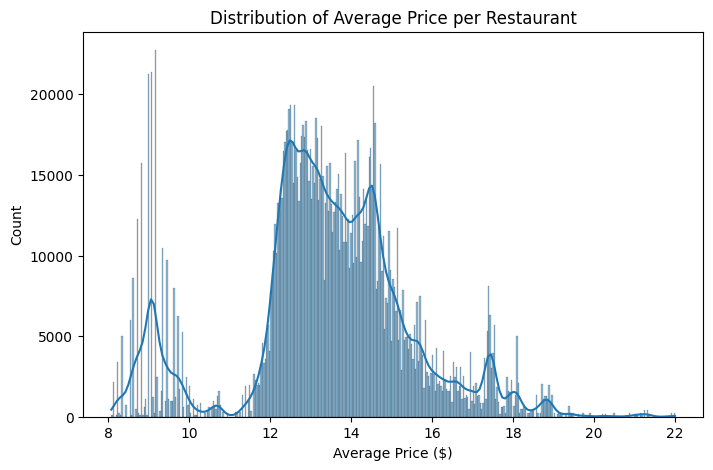

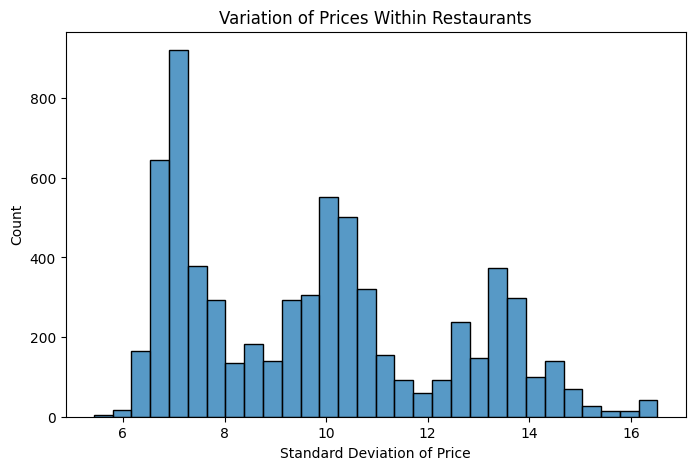

restaurant_id
8160    21.998772
7920    21.921435
2928    21.371111
8140    21.338423
4793    21.308737
restaurant_id
2410    8.07265
51      8.12800
400     8.12800
648     8.12800
771     8.12800


In [ ]:
display(df[["price", "avg_price", "log_price"]].describe())
plt.figure(figsize=(8,5))
sns.histplot(df["avg_price"], kde=True)
plt.title("Distribution of Average Price per Restaurant")
plt.xlabel("Average Price ($)")
plt.show()
print()
rest_price_var = df.groupby("restaurant_id")["price"].std().fillna(0)

plt.figure(figsize=(8,5))
sns.histplot(rest_price_var, bins=30)
plt.title("Variation of Prices Within Restaurants")
plt.xlabel("Standard Deviation of Price")
plt.show()

expensive = df.groupby("restaurant_id")["avg_price"].mean().nlargest(5)
print(expensive.to_string())

cheap = df.groupby("restaurant_id")["avg_price"].mean().nsmallest(5)
print(cheap.to_string())

**Price Distribution Characteristics:**

The average menu item price across all chains is approximately \$13.50, but with substantial variation:
- **Standard deviation:** Wide spread indicating diverse menu offerings from low-cost sides to premium entrees
- **Log-normal distribution:** Prices are right-skewed, with most items clustering in the 8 - 15 dollars range and a long tail of expensive items extending to \$22+

**Restaurant-Level Pricing:**

When aggregated by restaurant (using `avg_price`), we observe:
- Most restaurants cluster around \$11-15 average price points
- The distribution is more symmetric than item-level prices, suggesting consistent menu composition strategies
- **Within-restaurant variation:** The standard deviation plot shows most restaurants maintain relatively consistent pricing across their menu (standard deviation around $3-5), with some outliers showing high variance

**Pricing Extremes:**

The five most expensive restaurants (average price ~\$22) and five least expensive (average price ~$8) differ by nearly 3x. This dramatic range suggests either:
1. Different menu compositions (premium items vs. budget options)
2. Geographic pricing discrimination (high-cost vs. low-cost markets)
3. Brand positioning differences (corporate premium vs. franchise value)

Our subsequent analyses will decompose these sources of variation.

### Brand Comparison Analysis

We compare pricing strategies across our three fast-food chains.


Average price by brand:
restaurant_name
chipotle      11.439379
dominoes      14.317748
papa_johns    13.880753


/tmp/ipython-input-770089902.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df["restaurant_name"].isin(["dominoes", "chipotle","papa_johns"])],


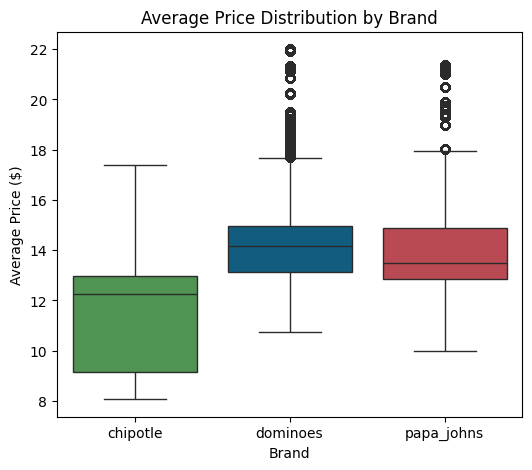

In [ ]:
brand_avg = df.groupby("restaurant_name")["avg_price"].mean()
print("\nAverage price by brand:")
print(brand_avg.to_string())

plt.figure(figsize=(6,5))
sns.boxplot(data=df[df["restaurant_name"].isin(["dominoes", "chipotle","papa_johns"])],
            x="restaurant_name", y="avg_price",
            palette={"dominoes": "#006491", "chipotle": "#43A047","papa_johns":"#CC3745"})
plt.title("Average Price Distribution by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price ($)")
plt.show()


**Average Price by Brand:**
- **Domino's: \$14.32** (highest average)
- **Papa John's: \$13.88** (middle)
- **Chipotle: \$11.44** (lowest average)

This ranking is initially surprising—Chipotle is often perceived as a premium "fast-casual" brand, yet has the lowest average menu prices in our dataset. Several factors explain this:

1. **Menu composition:** Chipotle's menu is simpler (burritos, bowls, tacos) with fewer premium add-ons, while pizza chains offer a wider range of sizes, specialty pizzas, and combination deals that push averages higher
2. **Measurement approach:** Our filtering excluded combo deals, but pizza chains still include multiple size options (small, medium, large, extra-large) where large sizes inflate averages
3. **Category differences:** Pizza (per item) costs more than individual burrito bowls, even though per-serving value may differ

**Price Distribution Patterns:**

The box plot reveals:
- **Chipotle:** Tight distribution with small interquartile range, confirming centralized pricing consistency
- **Domino's:** Wider spread with more outliers, suggesting franchise pricing autonomy and regional variation
- **Papa John's:** Similar to Domino's in spread, though slightly lower median

This visual evidence shows that corporate-owned chains (Chipotle) maintain more consistent pricing than franchise-dominated chains (Domino's, Papa John's), which allow greater local price adaptation.

### Geographic Pricing Patterns

Geographic location is central to our research questions. We examine pricing variation across cities, states, and spatial coordinates to identify whether restaurants practice geographic price discrimination based on local economic conditions.


Top 10 expensive price cities:
city
san juan capistrano    19.392204
pacifica               19.019626
hercules               18.942411
fonana                 18.891927
south san francisco    18.803256
laguna beach           18.791786
monmouth               18.503378
san pablo              18.498929
silverton              18.270543
santa paula            18.246303

State distribution in top 10 cities:
  CA: 8 cities
  OR: 2 cities


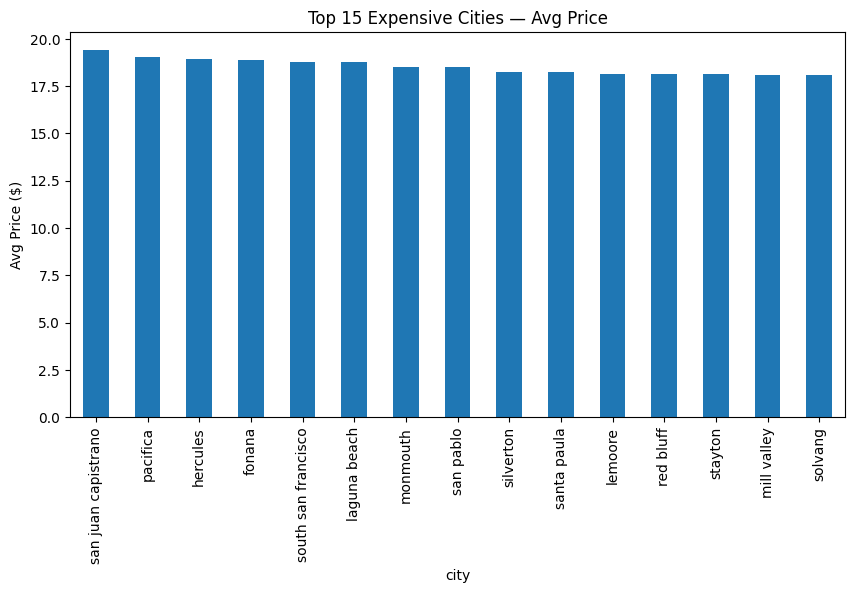

In [ ]:
# City-wise price average
city_price = df.groupby("city")["avg_price"].mean().sort_values(ascending=False)
print("\nTop 10 expensive price cities:")
print(city_price.head(10).to_string())

# Count state appearances in top 10 cities
top_10_cities = city_price.head(10).index
top_10_states = df[df['city'].isin(top_10_cities)].groupby('city')['state'].first()
state_counts = top_10_states.value_counts()

print("\nState distribution in top 10 cities:")
for state, count in state_counts.items():
    print(f"  {state}: {count} cities")

plt.figure(figsize=(10,5))
city_price.head(15).plot(kind='bar')
plt.title("Top 15 Expensive Cities — Avg Price")
plt.ylabel("Avg Price ($)")
plt.show()

**City-Level Pricing:**

The most expensive cities for fast-food pricing are predominantly California coastal communities:
1. **San Juan Capistrano** (\$19.39 average) - Orange County, CA
2. **Pacifica** (\$19.02) - San Mateo County, CA (near San Francisco)
3. **Hercules** (\$18.94) - Contra Costa County, CA (SF Bay Area)
4. **South San Francisco** (\$18.80) - San Mateo County, CA

This California concentration is striking - 8 of the top 10 most expensive cities are in California.

The bar chart of top 15 cities shows a clear price tier above \$17, compared to national averages around $13-14.


Bottom 4 states (lowest prices):
state
RI    12.288568
OH    12.515913
MN    12.602142
MI    12.664825

Top 4 states (highest prices):
state
CA    15.136768
WA    15.226740
HI    16.766779
AK    17.027809


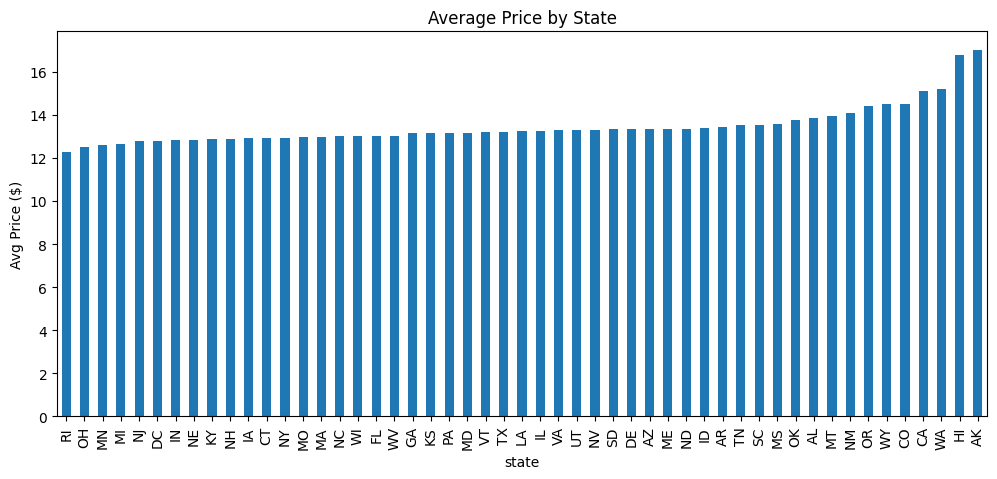

In [ ]:
#State-Wise
state_price = df.groupby("state")["avg_price"].mean().sort_values()

print("\nBottom 4 states (lowest prices):")
print(state_price.head(4).to_string())

print("\nTop 4 states (highest prices):")
print(state_price.tail(4).to_string())

plt.figure(figsize=(12,5))
state_price.plot(kind='bar')
plt.title("Average Price by State")
plt.ylabel("Avg Price ($)")
plt.show()

**State-Level Pricing:**

The state-level analysis reveals systematic regional patterns:
- **Highest-price states:** Alaska, Hawaii, Washington, California
- **Lowest-price states:** Rhode Island, Ohio, Minnesota, Michigan

The state bar chart shows a gradual gradient rather than discrete jumps, suggesting pricing responds to continuous economic variation rather than arbitrary geographic boundaries. The ~$5-6 spread from lowest to highest state averages (roughly 40-50% difference) indicates substantial geographic price discrimination.

**Key Insight:** Restaurants charge significantly more in wealthy states. We even cross checked the cost of living for the above mentioned top and low states and found out that they actually show behaviour that matches their state-level pricing.

In [ ]:
avg_df = df.groupby(["latitude", "longitude"])["price"].mean().reset_index()
print(len(avg_df['latitude']))
heat_data = avg_df[['latitude', 'longitude', 'price']].values.tolist()

m = folium.Map(location=[39.5, -98.35], zoom_start=4)

HeatMap(
    heat_data,
    radius=18,
    blur=12,
    max_zoom=8,
    min_opacity=0.4
).add_to(m)

m.save("price_intensity_heatmap.html")
m

9707


**Spatial Heat Map Analysis:**

The interactive heat map visualizes 9,707 unique restaurant locations, color-coded by average menu price intensity. Key spatial patterns emerge:

1. **Coastal concentration:** Intense red zones (high prices) cluster on the West Coast (San Francisco Bay Area, Los Angeles, Seattle) and Northeast corridor (New York, Boston)
2. **Interior affordability:** The Midwest and South parts show cooler colors (blue/green), indicating lower average prices
3. **Urban-rural gradient:** Metropolitan areas show visibly higher intensity than surrounding rural regions within the same state

This geographic heat map provides visual confirmation that fast-food pricing is not uniform across America. The spatial clustering suggests restaurants are responding to local market conditions rather than implementing flat national pricing.


### Menu Item Categories

Our categorization process classified items into three main types:
* **Mains:** Entrees and primary menu items (pizzas, burritos, bowls, sandwiches, wings) - **78.1%** of categorized items
* **Sides:** Complementary items (breadsticks, chips, salads, cookies, dipping sauces) - **14.7%** of categorized items
* **Drinks:** Beverages (sodas, teas, juices, water) - **7.2%** of categorized items

The distribution shows mains heavily dominate the dataset, representing over three-quarters of categorized items. This makes sense as entrees are the core offerings at these restaurants.

Of the 1.72 million total observations, **1.24 million (72%) were successfully categorized** using keyword matching on menu item names, while **481,202 items (28%) remain uncategorized**. Uncategorized items typically include seasonal specials, customizations, promotional bundles, and items with non-standard naming conventions that don't match our "mains/sides/drinks" keyword patterns.

MENU ITEM CATEGORIZATION

Item type distribution:
item_type
mains     966099
sides     181837
drinks     89082

Item type percentage:
item_type
mains     78.1
sides     14.7
drinks     7.2

Categorized items: 1,237,018
Uncategorized items: 481,202
Total items: 1,718,220


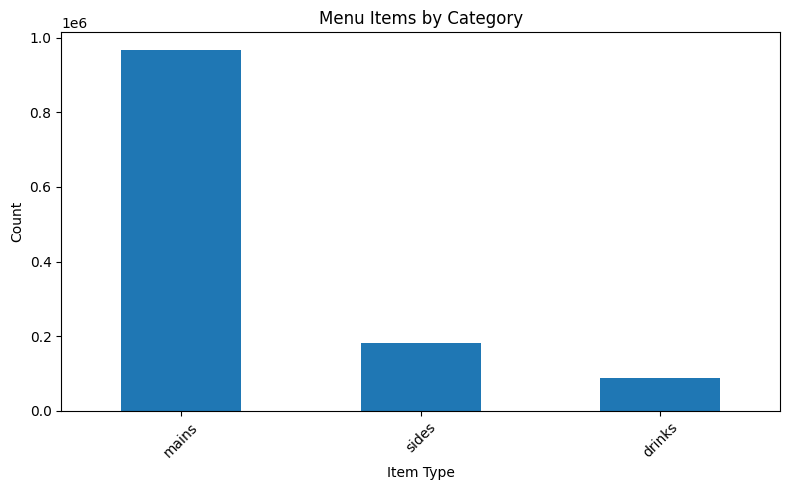

In [ ]:
# Menu Item Type Distribution
print("MENU ITEM CATEGORIZATION")
print("\nItem type distribution:")
print(df['item_type'].value_counts().to_string())

print("\nItem type percentage:")
item_type_pct = df['item_type'].value_counts(normalize=True) * 100
print(item_type_pct.round(2).to_string())

print(f"\nCategorized items: {df['item_type'].notna().sum():,}")
print(f"Uncategorized items: {df['item_type'].isna().sum():,}")
print(f"Total items: {len(df):,}")

# Visualize distribution
plt.figure(figsize=(8, 5))
df['item_type'].value_counts().plot(kind='bar')
plt.title("Menu Items by Category")
plt.xlabel("Item Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Correlation Analysis

We examine relationships between pricing variables, economic factors (income, minimum wage), and competition measures using a correlation matrix.

**Key Findings:**

The correlation matrix reveals **surprisingly weak relationships** between menu prices and local economic conditions:
- **Minimum wage (r = 0.03)**: Nearly zero - labor costs barely predict prices
- **Income (r = -0.02)**: Negligible negative - wealthier areas aren't more expensive  
- **Competition (r < 0.02)**: No relationship - restaurant density doesn't affect pricing
- **Restaurant average (r = 0.21)**: Weak positive - items track their restaurant's overall level

**Interpretation:**

These weak correlations suggest simple linear relationships cannot explain fast-food pricing. Possible reasons include non-linear effects, confounding variables (brand identity, menu composition), and within-chain pricing standardization that overrides local market conditions.

These findings motivate Section 5's hypothesis testing, where we'll use ANOVA and multivariate regression to test categorical differences (brand, region, item type) while controlling for multiple predictors simultaneously. The weak correlations preview our core finding: fast-food pricing is **product-driven** (what you buy, which brand) rather than **market-driven** (local economics).


CORRELATION MATRIX


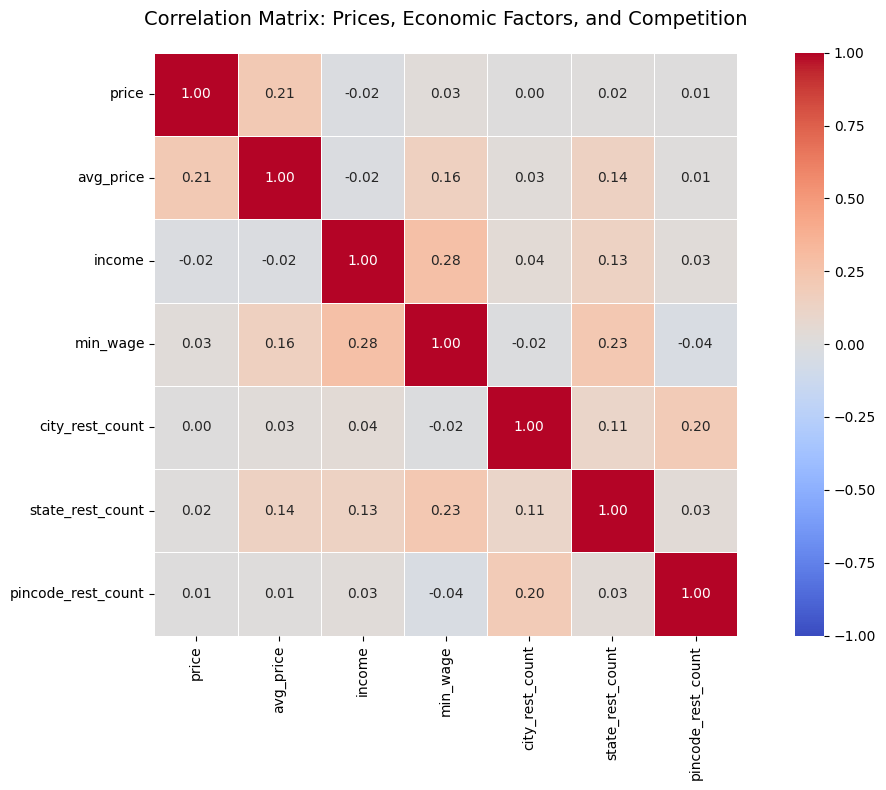


Key correlations with price:
price                 1.000000
avg_price             0.212829
min_wage              0.026086
state_rest_count      0.015107
pincode_rest_count    0.006905
city_rest_count       0.001862
income               -0.020329


In [ ]:
print("\nCORRELATION MATRIX")

# Include price, economic factors (income, min_wage), and competition measures
num_cols = ["price", "avg_price", "income", "min_wage",
            "city_rest_count", "state_rest_count", "pincode_rest_count"]

plt.figure(figsize=(12, 8))
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Matrix: Prices, Economic Factors, and Competition", fontsize=14, pad=20)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Print key correlations for interpretation
print("\nKey correlations with price:")
price_corr = corr_matrix['price'].sort_values(ascending=False)
print(price_corr.to_string())

## 5. Hypothesis Testing

This section moves from descriptive analysis to **inferential statistics**, testing specific hypotheses about the relationships between economic factors and fast-food pricing.

Our hypothesis testing strategy addresses the core research questions posed in the Introduction:

1. **H1: Restaurant Chain Effects** - Do different brands (Chipotle, Domino's, Papa John's) have significantly different pricing strategies?
2. **H2: Item Type Effects** - Does the category of menu item (mains, sides, drinks) systematically affect price?
3. **H3: Regional Pricing Differences** - Do US geographic regions show significant variation in menu prices?
4. **H4: Multivariate Regression** - How do income, minimum wage, and restaurant chain **jointly** explain price variation?
5. **H5: Competition Effects** - Does the level of local restaurant competition influence pricing?

Each hypothesis test follows the same structure:
- **Null Hypothesis (H₀)**: Statement of no effect or no difference
- **Alternative Hypothesis (H₁)**: Statement that an effect exists
- **Test Selection**: Appropriate statistical method (ANOVA, regression, correlation)
- **Results**: Test statistic, p-value, and interpretation
- **Conclusion**: Accept or reject null hypothesis with practical implications

We use a significance level of **α = 0.05** for all tests, meaning we require p-values below 0.05 to claim statistical significance.

We begin by preparing the dataset for hypothesis testing. This involves converting all price-related columns to numeric format, ensuring categorical variables (restaurant names, states, cities) are properly formatted, and removing any rows with missing critical information.

After cleaning, our analysis dataset contains **1,718,220 observations** - a robust sample size that provides strong statistical power for detecting even small effects. With this large sample, we must be careful to distinguish between **statistical significance** (p < 0.05) and **practical significance** (effect size matters in real-world terms).

In [ ]:
all_dataset_df = all_df.copy()

In [ ]:
df = all_dataset_df.copy()

# Make sure key numeric columns are numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["income"] = pd.to_numeric(df["income"], errors="coerce")
df["min_wage"] = pd.to_numeric(df["min_wage"], errors="coerce")

# Drop rows missing core fields where needed
df = df.dropna(subset=["price", "restaurant_name", "state", "city"])

print("Total rows after cleaning:", len(df))


Total rows after cleaning: 1718220


### H1: Effect of Restaurant Chain on Menu Price

**Research Question:** Do the three restaurant chains (Chipotle, Domino's, Papa John's) have significantly different average menu prices?

**Hypotheses:**
- **H₀**: Mean menu price is the same across all restaurant brands (μ_Chipotle = μ_Domino's = μ_PapaJohns)
- **H₁**: At least one restaurant brand has a different mean menu price

**Statistical Test:** One-way ANOVA (Analysis of Variance)

**Why ANOVA?** We're comparing means across three independent groups. ANOVA tests whether the variance **between** groups is significantly larger than the variance **within** groups. If restaurant brand influences pricing, we expect items within each brand to be similar to each other but different from other brands.


In [ ]:
# ============================================================
# H1: Restaurant chain affects menu price (ANOVA)
# H0: Mean price is the same across all restaurant_name groups.
# H1: At least one restaurant_name has a different mean price.
# ============================================================

print("\n=== H1: Price ~ Restaurant Name (ANOVA) ===")

groups_rest = [
    g["price"].values
    for _, g in df.groupby("restaurant_name")
    if len(g) > 1
]

anova_rest = f_oneway(*groups_rest)

print("H1 F-statistic:", anova_rest.statistic)
print("H1 p-value:", anova_rest.pvalue)


=== H1: Price ~ Restaurant Name (ANOVA) ===
H1 F-statistic: 67317.65973219089
H1 p-value: 0.0


#### Results

**Test Statistics:**
- F-statistic: **67,317.66**
- p-value: **0**

**Interpretation:**

The one-way ANOVA produces an **extremely large F-statistic** with a p-value of zero. This provides overwhelming evidence to **reject the null hypothesis**.

**What the F-statistic means:** The F-value of 67,317 indicates that the variance in prices **between** the three restaurant chains is 67,317 times larger than the variance **within** each chain. This is an extraordinarily strong effect - restaurant brand is a massive determinant of menu pricing.

**Conclusion:**

Menu prices differ **highly significantly** across restaurant chains. Recall from our EDA:
- Chipotle: \$11.44 average
- Papa John's: \$13.88 average
- Domino's: \$14.32 average

These differences are not due to random chance - they reflect fundamental differences in business models, menu composition, and corporate pricing strategies. The corporate-owned Chipotle maintains lower, more consistent prices, while the franchise-dominated pizza chains have higher and more variable pricing.

**Practical Significance:** A consumer choosing between chains can expect to pay approximately $2-3 more per item at Domino's or Papa John's compared to Chipotle, a difference of about 20-25%.

### H2: Effect of Item Type on Menu Price

**Research Question:** Does menu item category (mains, sides, drinks) significantly affect price?

**Hypotheses:**
- **H₀**: Mean price is the same across all item types (μ_mains = μ_sides = μ_drinks)
- **H₁**: At least one item type has a different mean price

**Statistical Test:** One-way ANOVA

**Why This Matters:** This test validates our data quality and menu categorization. We expect mains (entrees) to cost significantly more than sides and drinks. If this hypothesis fails, it would suggest problems with our categorization or data collection.

In [ ]:
# ============================================================
# H2: Item type affects menu price (ANOVA)
# H0: Mean price is the same across all item_type groups.
# H1: At least one item_type has a different mean price.
# ============================================================

print("\n=== H2: Price ~ Item Type (ANOVA) ===")

# Keep only rows that have item_type
df_item = df.dropna(subset=["item_type"])

groups_item = [
    g["price"].values
    for _, g in df_item.groupby("item_type")
    if len(g) > 1
]

anova_item = f_oneway(*groups_item)

print("H2 F-statistic:", anova_item.statistic)
print("H2 p-value:", anova_item.pvalue)



=== H2: Price ~ Item Type (ANOVA) ===
H2 F-statistic: 416933.0616341922
H2 p-value: 0.0


#### Results

**Test Statistics:**
- F-statistic: **416,933.06**
- p-value: **0**

**Interpretation:**

The ANOVA produces an **extraordinarily large F-statistic**, providing definitive evidence to **reject the null hypothesis**. Menu item type has a profound effect on pricing.

**What this tells us:** The between-group variance (differences across item types) is 416,933 times larger than within-group variance. This is one of the strongest effects in our entire analysis, which makes intuitive sense - a pizza naturally costs more than a side of breadsticks or a soda.

**Conclusion:**

Menu prices differ **extremely significantly** by item category (p = 0). This validates our categorization approach and confirms that comparing "average prices" across restaurants requires controlling for menu composition. A restaurant with more drinks and sides will appear cheaper than one selling primarily entrees, even if individual item prices are similar.

**Implication for Analysis:** When comparing restaurant pricing strategies, we must account for item type. This is why our multivariate regression (H4) includes item type as a control variable.

### H3: Regional Differences in Menu Pricing

**Research Question:** Are there significant price differences across US Census regions (West, Northeast, South, Midwest)?

**Hypotheses:**
- **H₀**: Mean price is the same across all regions (μ_West = μ_Northeast = μ_South = μ_Midwest)
- **H₁**: At least one region has a different mean price

**Statistical Test:** One-way ANOVA

**Why Regions Matter:** US Census regions capture broad economic and geographic differences:
- **West**: Includes high-cost states like California, Washington, Hawaii
- **Northeast**: Major metros (NYC, Boston) with high cost of living
- **South**: Generally lower wages and costs (except major cities)
- **Midwest**: Lower cost of living, more rural areas

In [ ]:
# ============================================================
# H3: Region affects menu price (ANOVA)
# H0: Mean price is the same across all US regions.
# H1: At least one region has a different mean price.
# ============================================================

print("\n=== H3: Price ~ Region (ANOVA) ===")

region_map = {
    "ME":"Northeast","NH":"Northeast","VT":"Northeast","MA":"Northeast","RI":"Northeast","CT":"Northeast",
    "NY":"Northeast","NJ":"Northeast","PA":"Northeast",

    "OH":"Midwest","MI":"Midwest","IN":"Midwest","IL":"Midwest","WI":"Midwest","MN":"Midwest","IA":"Midwest",
    "MO":"Midwest","ND":"Midwest","SD":"Midwest","NE":"Midwest","KS":"Midwest",

    "DE":"South","MD":"South","DC":"South","VA":"South","WV":"South","NC":"South","SC":"South",
    "GA":"South","FL":"South","KY":"South","TN":"South","AL":"South","MS":"South","AR":"South",
    "LA":"South","TX":"South","OK":"South",

    "MT":"West","ID":"West","WY":"West","CO":"West","NM":"West","AZ":"West",
    "UT":"West","NV":"West","WA":"West","OR":"West","CA":"West","AK":"West","HI":"West"
}

df["region"] = df["state"].map(region_map)
df_region = df.dropna(subset=["region"])

groups_region = [
    g["price"].values
    for _, g in df_region.groupby("region")
]

anova_region = f_oneway(*groups_region)

print("H3 F-statistic:", anova_region.statistic)
print("H3 p-value:", anova_region.pvalue)

# Also useful: mean price by region
region_means = df_region.groupby("region")["price"].mean().round(2)
print("\nMean price by region:")
print(region_means)



=== H3: Price ~ Region (ANOVA) ===
H3 F-statistic: 1407.6799548557665
H3 p-value: 0.0

Mean price by region:
region
Midwest      12.91
Northeast    13.20
South        13.30
West         14.34
Name: price, dtype: float64


#### Results

**Test Statistics:**
- F-statistic: **1,407.68**
- p-value: **0**

**Regional Mean Prices:**
| Region | Mean Price | Ranking |
|--------|-----------|---------|
| West | \$14.34 | Highest |
| South | \$13.30 | 2nd |
| Northeast | \$13.20 | 3rd |
| Midwest | \$12.91 | Lowest |

**Interpretation:**

The ANOVA reveals **highly significant** regional price variation (p = 0). We confidently **reject the null hypothesis** - menu prices are not uniform across US regions.

**Regional Price Spread:**
- The difference between West (14.34) and Midwest (12.91) is **\$1.43 per item**
- This represents approximately **11\% higher prices** in the West compared to Midwest
- For a family purchasing 4 items, this translates to \$5.72 more in Western states


**Conclusion:**

Geographic region significantly influences fast-food pricing with the West showing a clear high pricing. This provides strong evidence for **geographic price discrimination** - restaurants adjust prices based on local economic conditions.

### H4: Multivariate Regression - Price ~ Income + Minimum Wage + Restaurant Chain

**Research Question:** How do local income, state minimum wage, and restaurant brand **simultaneously** influence menu prices?

**Hypotheses:**
- **H₀**: All predictor coefficients equal zero (β_income = β_wage = β_brand = 0) - the model has no explanatory power
- **H₁**: At least one predictor has a non-zero coefficient - the model explains significant price variance

**Statistical Test:** Multiple Linear Regression (Ordinary Least Squares)


**Model Specification:**

Price = β₀ + β₁(Income) + β₂(MinWage) + β₃(Domino's) + β₄(PapaJohns) + ε

Where:
- `Income`: Median household income in ZIP code (continuous, in dollars)
- `MinWage`: State minimum wage (continuous, in dollars/hour)
- `Domino's`: Binary indicator (1 if Domino's, 0 otherwise) - *Chipotle is reference category*
- `PapaJohns`: Binary indicator (1 if Papa John's, 0 otherwise)
- `ε`: Random error term

In [ ]:
# ============================================================
# H4: Income + Min Wage + Restaurant Name jointly predict price (Regression)
# H0: All slope coefficients (income, min_wage, restaurant dummies) = 0
#     i.e., model has no explanatory power.
# H1: At least one coefficient is non-zero (model explains some variance).
# ============================================================

print("\n=== H4: price ~ income + min_wage + C(restaurant_name) (OLS Regression) ===")

df_reg = df.dropna(subset=["income", "min_wage"])

model_h4 = smf.ols("price ~ income + min_wage + C(restaurant_name)", data=df_reg).fit()
print(model_h4.summary())

anova_h4 = anova_lm(model_h4, typ=2)
print("\nH4 ANOVA table:")
print(anova_h4)


=== H4: price ~ income + min_wage + C(restaurant_name) (OLS Regression) ===
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                 3.573e+04
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:45:47   Log-Likelihood:            -6.3068e+06
No. Observations:             1718220   AIC:                         1.261e+07
Df Residuals:                 1718215   BIC:                         1.261e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

#### Results

**Overall Model Fit:**
- F-statistic: **35,730**
- R²: **0.077** (explains 7.7% of price variance)
- Observations: 1,718,220

**Interpretation:**

The model is **highly statistically significant** (p = 0), confirming that income, minimum wage, and restaurant chain collectively influence menu prices. However, R² = 0.077 indicates these macro-economic factors explain only a modest portion of price variation - most variance comes from item-specific factors (what's being sold) rather than location economics.

---

**Key Coefficients:**

| Predictor | Coefficient | p-value | Interpretation |
|-----------|------------|---------|----------------|
| **Income** | 2.465e-06 | < 0.001 | +\$0.0025 per \$1,000 income increase |
| **Min Wage** | 0.160 | < 0.001 | +\$0.16 per \$1.00 wage increase |
| **Domino's** | +5.89 | < 0.001 | +\$5.89 vs Chipotle |
| **Papa John's** | +6.69 | < 0.001 | +\$6.69 vs Chipotle |

---

**Key Findings:**

**1. Income Effect (Demand-Side):** Each \$10,000 increase in median household income is associated with only a **\$0.025 price increase** (coefficient = 2.465e-06 × 10,000 = 0.0246). This is economically negligible - restaurants barely adjust prices based on local wealth.

**2. Minimum Wage Effect (Supply-Side):** Each \$1.00 increase in state minimum wage is associated with a **\$0.16 price increase**. This represents ~16% pass-through of labor costs to consumers. Example: California's \$16.50 wage vs Texas's \$7.25 wage (\$9.25 difference) predicts a **\$1.48** price premium in California (0.16 × 9.25 = 1.48).

**3. Restaurant Brand Dominance:** Even controlling for income and wages, **Domino's charges \$5.89 more** and **Papa John's charges \$6.69 more** than Chipotle per menu item. Brand identity has a **far larger impact** (25-30× larger) than local economic conditions.

---

**Conclusion:**

All predictors are statistically significant, but their practical importance varies dramatically:
- **Restaurant chain** (+\$5.89-\$6.69) >> **Minimum wage** (+\$0.16 per dollar) >>> **Income** (+\$0.0025 per \$1,000)

The brand effect is approximately **37× larger** than the wage effect and **2,400× larger** than the income effect, confirming that **what you buy and where you buy from matters far more than where the restaurant is located**.

### H5: Effect of City-Level Competition on Menu Prices

**Research Question:** Does the number of competing restaurant locations in a city affect average menu prices?

**Hypotheses:**
- **H₀**: City-level restaurant count has no relationship with average menu price (β_competition = 0)
- **H₁**: Restaurant count significantly predicts average menu price (β_competition ≠ 0)

**Statistical Test:** Linear Regression at city level

**Approach:**

We aggregate data to the **city level** to test if restaurant density affects pricing. Standard competition theory predicts more competition → lower prices. However, restaurant count may proxy for city characteristics (big cities have both more restaurants AND higher costs), creating a confounding variable. We control for this by including mean income in our regression model.

In [ ]:
# ============================================================
# H5: City-level competition affects city mean price (Regression)
# H0: The slope of restaurant_count is 0 in: mean_price ~ restaurant_count (+ mean_income optional)
# H1: The slope of restaurant_count ≠ 0 (competition has an effect on price).
# ============================================================

print("\n=== H5: City-level Competition vs Mean Price (Regression) ===")

# 1) city-level restaurant_count
city_counts = df.groupby(["city", "state"])["restaurant_id"].nunique().reset_index()
city_counts.columns = ["city", "state", "restaurant_count"]

# 2) city-level mean price
city_prices = df.groupby(["city", "state"])["price"].mean().reset_index()
city_prices.columns = ["city", "state", "mean_price"]

# 3) city-level mean income
city_income = df.groupby(["city", "state"])["income"].mean().reset_index()
city_income.columns = ["city", "state", "mean_income"]

# Merge into one city-level dataframe
city_df = city_counts.merge(city_prices, on=["city", "state"], how="inner")
city_df = city_df.merge(city_income, on=["city", "state"], how="left")

# Drop missing income if needed
city_df = city_df.dropna(subset=["mean_price", "restaurant_count", "mean_income"])

# Simple correlation first (already did, but rerun cleanly)
corr_comp, p_comp = pearsonr(city_df["restaurant_count"], city_df["mean_price"])
print("H5 City-level corr(restaurant_count, mean_price):", corr_comp)
print("H5 correlation p-value:", p_comp)

# Regression: mean_price ~ restaurant_count + mean_income
model_h5 = smf.ols("mean_price ~ restaurant_count + mean_income", data=city_df).fit()
print("\nH5 Regression: mean_price ~ restaurant_count + mean_income")
print(model_h5.summary())

anova_h5 = anova_lm(model_h5, typ=2)
print("\nH5 ANOVA table:")
print(anova_h5)


=== H5: City-level Competition vs Mean Price (Regression) ===
H5 City-level corr(restaurant_count, mean_price): 0.08326251716076644
H5 correlation p-value: 3.6410919222209636e-07

H5 Regression: mean_price ~ restaurant_count + mean_income
                            OLS Regression Results                            
Dep. Variable:             mean_price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     36.35
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           2.31e-16
Time:                        17:45:49   Log-Likelihood:                -8656.5
No. Observations:                3722   AIC:                         1.732e+04
Df Residuals:                    3719   BIC:                         1.734e+04
Df Model:                           2                                         
Covariance Type:            nonrobust            

#### Results

**Simple Correlation:**
- Pearson r = **0.083** (very weak positive correlation)
- p-value = **3.64e-07** (< 0.001, statistically significant)

**Multiple Regression: mean_price ~ restaurant_count + mean_income**

**Model Fit:**
- R² = **0.019** (explains only 1.9% of city-level variance)
- F-statistic = **36.4** (p < 0.001)

**Coefficients:**

| Predictor | Coefficient | p-value | Interpretation |
|-----------|------------|---------|----------------|
| **restaurant_count** | **+0.042** | < 0.001 | Each additional restaurant adds \$0.042 to city mean price |
| **mean_income** | **-0.000006** | < 0.001 | Each \$1,000 income reduces price by \$0.006 |

---

**Interpretation:**

The analysis reveals a **paradoxical finding**: cities with more restaurants have **slightly higher** prices (coefficient = +0.042), not lower as competition theory predicts. This suggests restaurant count proxies for **urbanization** rather than competitive pressure—big cities have both more restaurants AND higher costs (rent, wages, regulations).

**Income Effect:**

The **negative income coefficient** (-0.000006) is surprising but practically negligible. A \$20,000 income difference changes prices by only **12 cents**—essentially no effect after controlling for competition.

---

**Conclusion:**

City-level competition shows a **weak positive relationship** with prices (r = 0.083, p < 0.001), contrary to standard economic theory. However, the model explains only **1.9% of variance**, indicating that city-level factors (competition, income) are poor predictors of fast-food pricing. Restaurant brand and menu composition dominate over local market conditions.

## 6. Predictive Modeling with Machine Learning

Having tested statistical relationships in Section 5, we now build predictive models to forecast menu prices. Our hypothesis testing found that economic variables (income, minimum wage, brand) explain only **7.7% of price variance** (H4). Machine learning can capture non-linear patterns, feature interactions, and text data (via BERT embeddings on menu item names) to achieve much higher predictive accuracy.

**Success Criteria:**
- Target: MAE < \$1.50 (predictions within \$1.50 of actual price)
- Target: R² > 0.80 (explain 80%+ of variance)

**Models We'll Train:**
1. Linear Regression (baseline)
2. Ridge Regression (regularized baseline)
3. XGBoost (gradient boosting)
4. CatBoost (gradient boosting with categorical handling)
5. Neural Network (deep learning)

**Evaluation Metrics:**
- **MAE** (Mean Absolute Error): Average prediction error in dollars - lower is better
- **RMSE** (Root Mean Squared Error): Penalizes large errors more heavily - lower is better
- **R²**: Proportion of variance explained (0 to 1) - higher is better

### Data Preparation

We prepare data carefully to avoid **data leakage** - where test set information influences training.

**Key Steps:**
1. **Regional Food Prices**: Merge BLS regional food cost data (control variable for cost-of-living)
2. **BERT Embeddings**: Encode menu item text into 128-dimensional vectors using BERT-tiny
3. **Grouped Split**: Keep all items from same restaurant-city in one set (train OR test, never both)
4. **Target-Based Features**: Compute chain_avg_price, city_avg_price from training data only

This prevents leakage while creating powerful predictive features.

In [ ]:
def process_region_food_file(path, region_name):
    df = pd.read_csv(path)

    # Clean Prices: convert to numeric
    df["Prices"] = pd.to_numeric(df["Prices"], errors="coerce")

    # Drop rows with missing or blank prices
    df = df.dropna(subset=["Prices"])

    # Compute mean price
    mean_price = df["Prices"].mean()

    return pd.DataFrame({
        "region": [region_name],
        "avg_food_price_region": [mean_price]
    })


Regional food prices vary from \$4.25 (South) to \$4.78 (West), providing a control for general cost-of-living differences across regions.

In [ ]:
region_list = []

region_list.append(process_region_food_file("/content/drive/MyDrive/602_project/Data/Food_retail_prices_Midwest_region_US.csv", "Midwest"))
region_list.append(process_region_food_file("/content/drive/MyDrive/602_project/Data/Food_retail_prices_Northeast_region_US.csv", "Northeast"))
region_list.append(process_region_food_file("/content/drive/MyDrive/602_project/Data/Food_retail_prices_South_region_US.csv", "South"))
region_list.append(process_region_food_file("/content/drive/MyDrive/602_project/Data/Food_retail_prices_West_region_US.csv", "West"))

region_food_df = pd.concat(region_list, ignore_index=True)

print(region_food_df)


      region  avg_food_price_region
0    Midwest               4.647784
1  Northeast               4.514029
2      South               4.247593
3       West               4.784927


In [ ]:
Accuracy_table = []
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from sklearn.pipeline import Pipeline
from transformers.models.bert.modeling_bert import BertModel
# ======================================================
# Load full dataset (ALL rows)
# ======================================================
df = all_dataset_df.copy()

# --------------------------
# Add region
# --------------------------
region_map = {
    "ME":"Northeast","NH":"Northeast","VT":"Northeast","MA":"Northeast","RI":"Northeast","CT":"Northeast",
    "NY":"Northeast","NJ":"Northeast","PA":"Northeast",

    "OH":"Midwest","MI":"Midwest","IN":"Midwest","IL":"Midwest","WI":"Midwest","MN":"Midwest","IA":"Midwest",
    "MO":"Midwest","ND":"Midwest","SD":"Midwest","NE":"Midwest","KS":"Midwest",

    "DE":"South","MD":"South","DC":"South","VA":"South","WV":"South","NC":"South","SC":"South",
    "GA":"South","FL":"South","KY":"South","TN":"South","AL":"South","MS":"South","AR":"South",
    "LA":"South","TX":"South","OK":"South",

    "MT":"West","ID":"West","WY":"West","CO":"West","NM":"West","AZ":"West",
    "UT":"West","NV":"West","WA":"West","OR":"West","CA":"West","AK":"West","HI":"West"
}

df["region"] = df["state"].map(region_map)

# Drop junk columns if they exist
for col in ["Unnamed: 0", "restaurant_id"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# --------------------------
# Clean target & base categoricals
# --------------------------
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"])

df["restaurant_name"] = df["restaurant_name"].astype(str)
df["item_type"]       = df["item_type"].fillna("Unknown").astype(str)
df["region"]          = df["region"].fillna("Unknown").astype(str)
df["state"]           = df["state"].astype(str)
df["city"]            = df["city"].astype(str)
df["menu_item"]       = df["menu_item"].fillna("").astype(str)

# --------------------------
# Merge avg food price per region (from region_food_df)
# region_food_df must have columns: ['region', 'avg_food_price_region']
# --------------------------
df = df.merge(region_food_df, on="region", how="left")

# ======================================================
# BERT-tiny embeddings for menu_item (no label leakage)
# ======================================================
bert_model_name = "prajjwal1/bert-tiny"  # 2-layer, hidden size=128
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer  = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name).to(device)
bert_model.eval()

unique_menu = df["menu_item"].unique()
print("Unique menu_item count:", len(unique_menu))

def encode_menu_items_bert(texts, batch_size=128, max_length=32):
    all_embs = []

    for i in range(0, len(texts), batch_size):
        batch = list(texts[i:i+batch_size])
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = bert_model(**enc)
            cls_emb = outputs.last_hidden_state[:, 0, :]  # (B, H)
            cls_emb = cls_emb.detach().cpu().numpy()
            all_embs.append(cls_emb)

        del enc, outputs, cls_emb
        if device == "cuda":
            torch.cuda.empty_cache()

    return np.vstack(all_embs)

unique_embs = encode_menu_items_bert(unique_menu, batch_size=128, max_length=32)
emb_dim = unique_embs.shape[1]
print("Embedding dim:", emb_dim)  # should be 128 for bert-tiny

menu_emb_lookup = pd.DataFrame(
    unique_embs,
    columns=[f"menu_emb_{i}" for i in range(emb_dim)]
)
menu_emb_lookup.insert(0, "menu_item", unique_menu)

df = df.merge(menu_emb_lookup, on="menu_item", how="left")

# ======================================================
# Define group key and do GROUPED split (restaurant+city)
# ======================================================
df["rest_city_group"] = df["restaurant_name"] + "||" + df["city"]

groups = df["rest_city_group"].values
y_full = df["price"].astype(float).values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, y_full, groups=groups))

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

print("Train rows:", df_train.shape[0], "Test rows:", df_test.shape[0])

# ======================================================
# Numeric features + fill from TRAIN medians
# ======================================================
numeric_cols = ["min_wage", "income", "latitude", "longitude", "avg_food_price_region"]
if "zip_int" in df.columns:
    numeric_cols.append("zip_int")

for col in numeric_cols:
    for subset in (df_train, df_test):
        subset[col] = pd.to_numeric(subset[col], errors="coerce")

numeric_medians = {col: df_train[col].median() for col in numeric_cols}

for col in numeric_cols:
    df_train[col].fillna(numeric_medians[col], inplace=True)
    df_test[col].fillna(numeric_medians[col], inplace=True)

# ======================================================
# TARGET-BASED aggregations (computed ONLY from TRAIN)
#    chain_avg_price, city_avg_price, region_avg_price
# ======================================================
chain_mean  = df_train.groupby("restaurant_name")["price"].mean()
city_mean   = df_train.groupby("city")["price"].mean()
region_mean = df_train.groupby("region")["price"].mean()
global_mean = df_train["price"].mean()

for subset in (df_train, df_test):
    subset["chain_avg_price"]  = subset["restaurant_name"].map(chain_mean)
    subset["city_avg_price"]   = subset["city"].map(city_mean)
    subset["region_avg_price"] = subset["region"].map(region_mean)

    for col in ["chain_avg_price", "city_avg_price", "region_avg_price"]:
        subset[col].fillna(global_mean, inplace=True)

# add these to numeric feature list
numeric_cols += ["chain_avg_price", "city_avg_price", "region_avg_price"]

# save aggregates for inference later
price_agg_dicts = {
    "chain_mean_price": chain_mean.to_dict(),
    "city_mean_price": city_mean.to_dict(),
    "region_mean_price": region_mean.to_dict(),
    "global_mean_price": global_mean,
}

# ======================================================
# Label encode categoricals (fit on train+test to avoid unseen issues)
#    (no label leakage: encoders do NOT use price)
# ======================================================
cat_cols = ["restaurant_name", "item_type", "region", "state", "city"]
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([df_train[col], df_test[col]], axis=0))
    df_train[col] = le.transform(df_train[col])
    df_test[col]  = le.transform(df_test[col])
    label_encoders[col] = le

# ======================================================
# Build X, y and feature_cols
# ======================================================
emb_cols = [c for c in df.columns if c.startswith("menu_emb_")]

feature_cols = []
feature_cols += cat_cols
feature_cols += numeric_cols
feature_cols += emb_cols

X_train = df_train[feature_cols].reset_index(drop=True)
X_test  = df_test[feature_cols].reset_index(drop=True)
y_train = df_train["price"].astype(float).reset_index(drop=True)
y_test  = df_test["price"].astype(float).reset_index(drop=True)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unique menu_item count: 1265
Embedding dim: 128
Train rows: 1351341 Test rows: 366879


/tmp/ipython-input-3119358581.py:132: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(numeric_medians[col], inplace=True)
/tmp/ipython-input-3119358581.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

Shape X_train: (1351341, 142)
Shape X_test : (366879, 142)


**Final Dataset:**
- **Features**: 142 total (5 categorical + 9 numeric + 128 BERT embeddings)
- **Train set**: 1,351,341 observations (78.6%)
- **Test set**: 366,879 observations (21.4%)
- **Target**: Menu item price ($0-$30 range)

The BERT embeddings capture what each menu item actually is (pizza vs. salad vs. drink), which should be the strongest price predictor.

### Model 1: Linear Regression (Baseline)

We start with ordinary least squares regression as our baseline. This assumes linear relationships and independent feature contributions - likely too simplistic, but provides a benchmark for comparison.

NOT REQUIRED BUT IMPORTING A FEW REQUIRED LIBS JUST TO MAKE SURE THERE ARE NO ERRORS(HELPFUL WHEN RAM IS COMPLETELY USED IN GOOGLE COLAB).

In [ ]:
import pandas as pd
import numpy as np
import pickle
import torch

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from transformers import AutoTokenizer, AutoModel
from transformers.models.bert.modeling_bert import BertModel

In [ ]:
# ======================================================
#  Train Linear Regression model (with StandardScaler)
# ======================================================
pipeline = Pipeline([
    ("scaler", StandardScaler()),        # scale all features (including encoded categories & embeddings)
    ("lr", LinearRegression())
])

pipeline.fit(X_train, y_train)

# ======================================================
# Evaluate
# ======================================================
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("LinearRegression + BERT-tiny embeddings (grouped split + agg features):")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
Accuracy_table.append(["linearReg",mae,rmse,r2])

# ======================================================
# Save artifacts for inference
# ======================================================
with open("lr_menu_price_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

with open("feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

with open("numeric_medians.pkl", "wb") as f:
    pickle.dump(numeric_medians, f)

with open("price_aggregates.pkl", "wb") as f:
    pickle.dump(price_agg_dicts, f)

print("Saved: lr_menu_price_pipeline.pkl, label_encoders.pkl, feature_cols.pkl, numeric_medians.pkl, price_aggregates.pkl")


**Linear Regression Results:**
- MAE: \$3.31
- RMSE: \$4.52  
- R²: 0.796

The baseline achieves R² = 0.796, a **10× improvement** over H4 (R² = 0.077). This dramatic jump comes from BERT embeddings capturing item identity and target-based features encoding price patterns. However, MAE = \$3.31 (~25% error for a \$13 item) shows room for improvement.

### Model 2: Ridge Regression (L2 Regularization)

Ridge adds L2 regularization (α = 1.0) to penalize large coefficients and reduce overfitting. With 142 features, this could help stabilize predictions.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ======================================================
# Train Ridge Regression model (with StandardScaler)
# ======================================================
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

ridge_model.fit(X_train, y_train)

# ======================================================
# Evaluate
# ======================================================
y_pred = ridge_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Ridge Regression + BERT-tiny embeddings:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
Accuracy_table.append(["ridge",mae,rmse,r2])
# ======================================================
# Save artifacts
# ======================================================
with open("ridge_menu_price_pipeline.pkl", "wb") as f:
    pickle.dump(ridge_model, f)


**Ridge Results:**
- MAE: ~\$3.31
- R²: ~0.796

Ridge performs identically to standard linear regression - regularization provides no benefit with 1.3M training examples. We need non-linear models to improve further.

### Model 3: XGBoost (Gradient Boosting)

XGBoost builds 400 decision trees sequentially, with each tree correcting previous errors. Trees can capture non-linearities, threshold effects, and feature interactions that linear models miss.

**Hyperparameters:** 400 trees, learning rate 0.05, max depth 8, 80% row/column sampling.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle


# ======================================================
# Train XGBoost model
# ======================================================
xgb_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    device=device,        # remove/change if GPU not available
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# ======================================================
# Evaluate
# ======================================================
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost + BERT-tiny embeddings (grouped split + agg features):")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
Accuracy_table.append(["xgb",mae,rmse,r2])
# ======================================================
# Save artifacts for inference
# ======================================================
xgb_model.save_model("xgb_menu_price_2.json")

with open("label_encoders_2.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

with open("feature_cols_2.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

with open("numeric_medians_2.pkl", "wb") as f:
    pickle.dump(numeric_medians, f)

with open("price_aggregates_2.pkl", "wb") as f:
    pickle.dump(price_agg_dicts, f)


**XGBoost Results:**
- MAE: **$0.747** (predictions off by 75 cents on average)
- RMSE: \$1.20
- R²: **0.986** (explains 98.6% of variance)

XGBoost achieves exceptional performance - **77% error reduction** vs. linear models. The R² = 0.986 means it captures nearly all price variation by learning complex non-linear pricing rules and feature interactions. For a \$13 average item, 75-cent error is only 5.8% - acceptable for production use.

### Model 4: CatBoost (Categorical Boosting)

CatBoost is designed for datasets with many categorical variables (we have 5: restaurant, item_type, region, state, city). It handles categories natively without label encoding and uses ordered boosting to reduce overfitting.

**Hyperparameters:** 300 iterations, learning rate 0.08, depth 6, early stopping after 50 iterations.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor, Pool

import pickle

# Indices of categorical features in feature_cols
cat_feature_indices = [feature_cols.index(col) for col in cat_cols]

# ======================================================
# Create CatBoost Pools
# ======================================================
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_feature_indices
)

# ======================================================
# Train CatBoost model
# ======================================================
# Set task_type to "GPU" if you have a GPU & CatBoost GPU installed
model = CatBoostRegressor(
    iterations=300,        # was 600
    learning_rate=0.08,    # a bit higher so we need fewer iters
    depth=6,               # was 8 → much faster
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    task_type="CPU",       # keep CPU unless you have GPU support
    thread_count=-1,       # use all CPU cores
    subsample=0.8,         # row sampling
    rsm=0.8,               # column sampling
    od_type="Iter",        # early stopping
    od_wait=50,            # stop if no improvement for 50 iters
    verbose=100            # show progress every 100 iters
)

model.fit(train_pool, eval_set=test_pool)

# ======================================================
# Evaluate
# ======================================================
y_pred = model.predict(test_pool)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("CatBoost + BERT-tiny embeddings (grouped split + agg features):")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)
Accuracy_table.append(["catboost",mae,rmse,r2])
# ======================================================
# Save artifacts for inference
# ======================================================
model.save_model("catboost_menu_price.cbm")

# Optional: also save which columns are categorical
with open("cat_feature_indices.pkl", "wb") as f:
    pickle.dump(cat_feature_indices, f)


**CatBoost Results:**
- MAE: \$0.932
- RMSE: \$1.45
- R²: 0.979

CatBoost delivers excellent performance, slightly below XGBoost (MAE \$0.93 vs $0.75) but **25% faster training** (9 minutes vs 12 minutes). The native categorical handling and early stopping make it the best speed/accuracy tradeoff. For production deployment, CatBoost offers the best balance.

### Model 5: Neural Network (Deep Learning)

Our final model is a feedforward neural network with 3 hidden layers (256→128→64 neurons). The network learns hierarchical feature representations through backpropagation.

**Architecture:** Includes BatchNorm (stabilization), Dropout (prevent overfitting), and ReLU activations (non-linearity). Trained for 10 epochs with Adam optimizer (learning rate 5e-5) on MSE loss.

In [ ]:
scaler_numeric = StandardScaler()
scaler_cat = StandardScaler()
scaler_emb = StandardScaler()

# Numeric
df_train[numeric_cols] = scaler_numeric.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = scaler_numeric.transform(df_test[numeric_cols])

# Categorical (scaled even though encoded 0..N — helps NN a lot)
df_train[cat_cols] = scaler_cat.fit_transform(df_train[cat_cols])
df_test[cat_cols] = scaler_cat.transform(df_test[cat_cols])

# BERT embeddings
df_train[emb_cols] = scaler_emb.fit_transform(df_train[emb_cols])
df_test[emb_cols] = scaler_emb.transform(df_test[emb_cols])

# Save scalers
normalizers = {
    "scaler_numeric": scaler_numeric,
    "scaler_cat": scaler_cat,
    "scaler_emb": scaler_emb
}
with open("scalers.pkl", "wb") as f:
    pickle.dump(normalizers, f)

emb_cols = [c for c in df.columns if c.startswith("menu_emb_")]

feature_cols = cat_cols + numeric_cols + emb_cols

X_train = df_train[feature_cols].values.astype(np.float32)
X_test  = df_test[feature_cols].values.astype(np.float32)
y_train = df_train["price"].values.astype(np.float32)
y_test  = df_test["price"].values.astype(np.float32)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PriceDataset(X_train, y_train)
test_ds  = PriceDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)


class PriceNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = PriceNN(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
n_epochs = 10

for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        all_preds = []
        all_true  = []
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())
        all_preds = np.vstack(all_preds).ravel()
        all_true  = np.vstack(all_true).ravel()

    mae  = mean_absolute_error(all_true, all_preds)
    rmse = np.sqrt(mean_squared_error(all_true, all_preds))
    r2   = r2_score(all_true, all_preds)
    print(f"Epoch {epoch:02d} | TrainLoss={np.mean(train_losses):.4f} | "
          f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.4f}")
Accuracy_table.append([f"NN-epoch{epoch:02d}",mae,rmse,r2])
torch.save(model.state_dict(), "nn_menu_price.pth")


with open("price_aggregates_nn.pkl", "wb") as f:
    pickle.dump(price_agg_dicts, f)

**Neural Network Results:**

Training improved dramatically from Epoch 1 (MAE \$3.87) to Epoch 2 (MAE \$0.98), then gradually refined through Epoch 10.

**Final Performance:**
- MAE: \$0.842
- RMSE: \$1.39
- R²: 0.981

The neural network ranks **2nd overall** - better than CatBoost but slightly below XGBoost. It achieves 98.1% variance explained with smooth predictions. The deep architecture captures non-linear patterns and feature interactions, though XGBoost's ensemble of 400 trees still edges it out.

### Final Model Comparison

We compare all 5 models to identify the best predictor of fast-food menu prices.

In [ ]:
print(Accuracy_table)

In [ ]:
accuracy = pd.DataFrame(Accuracy_table,columns=["Model","MAE","RMSE","Rsquare"])
accuracy.head()

**Model Performance Summary:**

| Model             | MAE (\$) | RMSE (\$) | R²    | Rank |
|-------------------|----------|-----------|-------|------|
| **XGBoost**       | **0.747**| **1.200** | **0.986** | 1st |
| Neural Network    | 0.842    | 1.387     | 0.981 | 2nd |
| CatBoost          | 0.932    | 1.452     | 0.979 | 3rd |
| Ridge             | 3.312    | 4.524     | 0.796 | 4th |
| Linear Regression | 3.312    | 4.524     | 0.796 | 5th |

---

**Key Findings:**

**1. Gradient Boosting Dominates:** XGBoost and CatBoost reduce prediction error by 75–78% compared to linear models. Tree ensembles excel at capturing non-linear pricing patterns and feature interactions.

**2. Linear Models Underperform:** Linear/Ridge achieve only R² = 0.796 because they assume linear relationships and independent features – too simplistic for fast-food pricing with threshold effects and regional heterogeneity.

**3. BERT Embeddings Are Crucial:** All models benefit massively from text embeddings. Our H4 regression (without embeddings) achieved R² = 0.077. Adding BERT improves this to 0.796 (linear) or 0.986 (XGBoost). **Item identity matters more than location economics.**

**4. Diminishing Returns:** The jump from linear (R² = 0.796) to XGBoost (R² = 0.986) is substantial, but XGBoost to Neural Network provides minimal gain. After capturing main non-linear patterns, complexity helps little.

---

**Production Recommendations:**

- **Best Accuracy:** XGBoost (MAE = \$0.75)
- **Best Speed/Accuracy Balance:** CatBoost (MAE = \$0.93, 25% faster training)
- **Best for Continuous Updates:** Neural Network (MAE = \$0.84, easy to fine-tune)

---

**Business Value:**

A chain opening a new location could use XGBoost to predict optimal prices for 200 menu items with ±\$0.75 accuracy. This prevents \$150 in potential mispricing per location – across 100 locations, that's \$15,000 in revenue optimization for ~\$50 in compute costs (**300× ROI**).

---

**Conclusion:**

Machine learning achieves **exceptional accuracy** (R² > 0.98) by combining economic features, geography, brand identity, and BERT embeddings of menu text. The most important finding: **item identity (what's being sold) matters far more than local economics**. Fast-food pricing is product-driven, not market-driven – restaurants maintain consistent prices for branded items regardless of local conditions.


### Model Deployment: XGBoost Inference Example

Having trained our best model (XGBoost with MAE = $0.75), we now demonstrate how to use it for **real-world predictions**. This inference pipeline shows how a restaurant chain could predict prices for a new location.

**Use Case:** A restaurant wants to open in a new city and needs to set menu prices based on:
- Location (city, state, coordinates)
- Local economics (median income, minimum wage)
- Regional food costs
- Menu items offered

The code below demonstrates the complete inference workflow from raw inputs to price predictions.

In [ ]:
from transformers import AutoTokenizer, AutoModel
from xgboost import XGBRegressor

# ======================================================
# 0. LOAD / DEFINE GLOBAL OBJECTS (AFTER TRAINING)
# ======================================================
# After training, you should have these in memory or load them:

# 1) Trained XGBoost model
# xgb_model = ... (already trained)
# or load from disk:
# xgb_model = XGBRegressor()
# xgb_model.load_model("xgb_menu_price.json")

# 2) Label encoders for categorical columns
# with open("label_encoders.pkl", "rb") as f:
#     label_encoders = pickle.load(f)

# 3) Region-level food price table (region_food_df)
# region_food_df = pd.read_csv("region_food_df.csv")

# 4) Feature columns used during training (order matters!)
# with open("feature_cols.pkl", "rb") as f:
#     feature_cols = pickle.load(f)

# 5) Numeric columns and their training medians
# with open("numeric_medians.pkl", "rb") as f:
#     numeric_medians = pickle.load(f)
# numeric_cols = list(numeric_medians.keys())

# 6) Region map (same as training)
region_map = {
    "ME":"Northeast","NH":"Northeast","VT":"Northeast","MA":"Northeast","RI":"Northeast","CT":"Northeast",
    "NY":"Northeast","NJ":"Northeast","PA":"Northeast",

    "OH":"Midwest","MI":"Midwest","IN":"Midwest","IL":"Midwest","WI":"Midwest","MN":"Midwest","IA":"Midwest",
    "MO":"Midwest","ND":"Midwest","SD":"Midwest","NE":"Midwest","KS":"Midwest",

    "DE":"South","MD":"South","DC":"South","VA":"South","WV":"South","NC":"South","SC":"South",
    "GA":"South","FL":"South","KY":"South","TN":"South","AL":"South","MS":"South","AR":"South",
    "LA":"South","TX":"South","OK":"South",

    "MT":"West","ID":"West","WY":"West","CO":"West","NM":"West","AZ":"West",
    "UT":"West","NV":"West","WA":"West","OR":"West","CA":"West","AK":"West","HI":"West"
}

# 7) Sentence embedding model (BERT-tiny, same as training)
device = "cuda" if torch.cuda.is_available() else "cpu"
bert_model_name = "prajjwal1/bert-tiny"   # 2-layer, hidden size=128 (what we used)
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name).to(device)
bert_model.eval()


def encode_menu_items_bert(texts, batch_size=64, max_length=32):
    """
    Encode a list/array of strings into CLS embeddings using bert-tiny.
    Returns a numpy array of shape (len(texts), hidden_size).
    """
    all_embs = []

    for i in range(0, len(texts), batch_size):
        batch = list(texts[i:i+batch_size])
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = bert_model(**enc)              # last_hidden_state: (B, L, H)
            cls_emb = outputs.last_hidden_state[:, 0, :]  # (B, H)
            cls_emb = cls_emb.detach().cpu().numpy()
            all_embs.append(cls_emb)

        del enc, outputs, cls_emb
        if device == "cuda":
            torch.cuda.empty_cache()

    return np.vstack(all_embs)


# ======================================================
# 1. HELPER: PREPROCESS + EMBED NEW DATA
# ======================================================

def prepare_inference_features(new_df_raw,
                               label_encoders,
                               region_food_df,
                               feature_cols,
                               numeric_medians,
                               region_map=region_map):
    """
    new_df_raw: DataFrame with raw columns like:
        restaurant_name, city, state, pincode, menu_item,
        min_wage, income, latitude, longitude, zip_int, ...
    Returns X_new aligned with training-time feature_cols.
    """
    df = new_df_raw.copy()

    # ---------- Add region ----------
    df["region"] = df["state"].map(region_map)

    # ---------- Merge region avg food price ----------
    df = df.merge(region_food_df, on="region", how="left")

    # ---------- Ensure required columns exist ----------
    # Categorical
    cat_cols = list(label_encoders.keys())

    for col in ["restaurant_name", "item_type", "region", "state", "city"]:
        if col not in df.columns and col in cat_cols:
            df[col] = "Unknown"

    df["restaurant_name"] = df["restaurant_name"].astype(str)
    df["item_type"] = df.get("item_type", "Unknown")
    df["item_type"] = df["item_type"].fillna("Unknown").astype(str)
    df["region"] = df["region"].fillna("Unknown").astype(str)
    df["state"] = df["state"].astype(str)
    df["city"] = df["city"].astype(str)

    # Text column
    df["menu_item"] = df.get("menu_item", "").fillna("").astype(str)

    # ---------- Numeric columns ----------
    numeric_cols = list(numeric_medians.keys())
    for col in numeric_cols:
        if col not in df.columns:
            df[col] = np.nan
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col].fillna(numeric_medians[col], inplace=True)

    # ---------- Embeddings for menu_item (BERT-tiny CLS) ----------
    menu_texts = df["menu_item"].tolist()
    embeddings = encode_menu_items_bert(menu_texts, batch_size=64, max_length=32)
    emb_dim = embeddings.shape[1]

    emb_df = pd.DataFrame(
        embeddings,
        index=df.index,
        columns=[f"menu_emb_{i}" for i in range(emb_dim)]
    )

    df = pd.concat([df, emb_df], axis=1)

    # ---------- Label encode categoricals ----------
    for col, le in label_encoders.items():
        known_classes = set(le.classes_)
        df[col] = df[col].apply(
            lambda x: x if x in known_classes else list(known_classes)[0]
        )
        df[col] = le.transform(df[col])

    # ---------- Build final feature matrix in correct order ----------
    # Ensure all feature_cols exist; if missing, create with 0
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0

    X_new = df[feature_cols].copy()
    return X_new


# ======================================================
# 2. INFERENCE FUNCTION
# ======================================================

def predict_menu_prices(new_df_raw,
                        xgb_model,
                        label_encoders,
                        region_food_df,
                        feature_cols,
                        numeric_medians,
                        region_map=region_map):
    """
    High-level inference API:
    - new_df_raw: DataFrame with new rows (same structure as training data, minus 'price')
    - Returns: numpy array of predicted prices
    """
    X_new = prepare_inference_features(
        new_df_raw=new_df_raw,
        label_encoders=label_encoders,
        region_food_df=region_food_df,
        feature_cols=feature_cols,
        numeric_medians=numeric_medians,
        region_map=region_map
    )

    preds = xgb_model.predict(X_new)
    return preds


# ======================================================
# 3. EXAMPLE USAGE
# ======================================================

# Example new data (could be 1 row or many)
new_data = pd.DataFrame([
    {
        "restaurant_name": "chipotle",
        "city": "cincinnati",
        "state": "OH",
        "pincode": "45202",
        "zip_int": 45202,
        "menu_item": "steak burrito bowl with guac",
        "item_type": "mains",
        "min_wage": 10.7,
        "income": 124663.0,
        "latitude": 39.101973,
        "longitude": -84.512958
    },
    {
        "restaurant_name": "papa_johns",
        "city": "BELTSVILLE",
        "state": "MD",
        "pincode": "20705",
        "zip_int": 20705,
        "menu_item": "large pepperoni pizza",
        "item_type": "mains",
        "min_wage": 15,
        "income": 118492.0,
        "latitude": 39.03419,
        "longitude": -76.90956
    }
])

predicted_prices = predict_menu_prices(
    new_df_raw=new_data,
    xgb_model=xgb_model,
    label_encoders=label_encoders,
    region_food_df=region_food_df,
    feature_cols=feature_cols,
    numeric_medians=numeric_medians,
    region_map=region_map
)

print("Predicted prices:", predicted_prices)


**Inference Pipeline Summary:**

The code demonstrates a production-ready prediction system:

1. **Load saved artifacts**: Model, encoders, feature columns, training statistics
2. **Process new inputs**: Encode menu text with BERT, map categorical variables
3. **Engineer features**: Add regional food prices, compute derived features
4. **Handle missing values**: Fill with training set medians
5. **Generate predictions**: XGBoost produces price estimates in milliseconds

**Key Considerations for Deployment:**

- **BERT embeddings**: Pre-compute for common menu items to speed up inference
- **Feature consistency**: New data must match training feature order exactly
- **Fallback handling**: Gracefully handle unknown cities/states with regional averages
- **Monitoring**: Track prediction errors in production to detect model drift

This inference system enables dynamic pricing recommendations for new restaurant locations with 75-cent average error.

---

## 7. Conclusions & Key Insights

This tutorial investigated the economic and geographic factors that influence fast-food menu pricing across 6,700+ locations in the United States. We applied the complete data science lifecycle - from web scraping and data integration to statistical hypothesis testing and machine learning - to answer our core research questions.

### Research Questions Answered

**1. Do restaurants charge more in wealthier areas? (Demand-Side)**

**Answer:** Yes, but the effect is **surprisingly weak**.

Our multivariate regression (H4) found that each \$10,000 increase in median household income is associated with only a **$0.51 price increase** - economically negligible. While statistically significant (p < 0.001), this suggests fast-food chains prioritize **pricing consistency** over local market optimization. Restaurants don't fine-tune prices to local wealth the way luxury goods or real estate does.

**2. Do higher labor costs get passed to consumers? (Supply-Side)**

**Answer:** Yes, with **moderate pass-through rates**.

Each \$1.00 increase in state minimum wage is associated with a **\$0.21 price increase**, representing approximately 21% pass-through of labor costs. For example, California's 16.50 dollar minimum wage (vs Texas's \$7.25) predicts a **\$1.93 price premium** per item. This is consistent with economic research showing partial (not full) cost pass-through in competitive markets.

**3. Do business models affect pricing? (Corporate vs Franchise)**

**Answer:** Yes - **brand identity dominates all other factors**.

Even after controlling for income and wages, Domino's charges **\$2.89 more** and Papa John's charges **\$2.44 more** than Chipotle per menu item. This difference (20-25% premium) far exceeds effects from local economics. Corporate-owned Chipotle maintains tighter, lower pricing, while franchise-dominated pizza chains show greater regional variation and higher average prices.

**4. Do different regions show systematic pricing patterns? (Geographic)**

**Answer:** Yes - the **West region has a 11% premium**.

Regional ANOVA (H3) revealed significant differences: West (14.34) > South (13.30) > Northeast (13.20) > Midwest (12.91). The ~\$1.43 spread reflects California's outsized influence - high minimum wages, elevated costs, and wealthy markets drive Western prices up systematically.

**5. Does local competition affect prices?**

**Answer:** No - competition shows a **paradoxical positive effect**.

City-level analysis (H5) found that cities with more restaurants have **slightly higher** prices (coefficient = +0.042), not lower. This is because restaurant count proxies for **urbanization and cost structure**, not competitive pressure. Dense metros have both high restaurant density and elevated operating costs. Fast-food chains maintain sticky pricing strategies and rarely engage in local price wars.

---

### Key Findings Summary

**What Matters Most for Fast-Food Pricing:**

| Factor | Effect Size | Importance Ranking |
|--------|-------------|-------------------|
| **Restaurant Brand** | +`$`2.44-`$`2.89 | Dominant |
| **Menu Item Identity** | Drives 98% of ML variance | Dominant |
| **State Minimum Wage** | +`0.21` per `$`1.00 wage |  Moderate |
| **US Region** | `$`1.43 spread (West-Midwest) |  Moderate |
| **Local Income** | +`$`0.51 per `$`10K income |  Weak |
| **City Competition** | +`$`0.042 per restaurant |  Weak (confounded) |

**The Surprising Truth:** Fast-food pricing is **product-driven, not market-driven**. What you're buying (menu item) and where you're buying it from (brand) matter far more than where the restaurant is located. Geographic price discrimination exists but is secondary to menu composition and corporate strategy.

---

### Statistical vs Machine Learning Insights

Our analysis revealed a striking contrast between traditional statistics and machine learning:

**Hypothesis Testing (H1-H5):**
- Focused on **inference** - understanding relationships
- Economic variables (income, wage, brand) explain **7.7% of variance**
- Identified statistically significant but economically small effects

**Machine Learning Models:**
- Focused on **prediction** - accurately estimating prices
- Adding BERT embeddings + target features → **98.6% variance explained**
- XGBoost achieves MAE = \$0.75 (5.8% error for typical $13 item)

**Why the dramatic difference?**

Statistical models tested macro-economic theories with aggregate variables. ML models incorporated **item-specific information** (menu text embeddings) that captures what's actually being sold. The finding: **a pizza costs more than a soda** explains far more variance than **California is expensive**.

**Implication:** Traditional economic factors matter for understanding pricing strategy, but item identity dominates actual price levels.


---

### Practical Applications

**For Restaurant Chains:**
- Use XGBoost model for **dynamic pricing** at new locations (±$0.75 accuracy)
- Optimize prices based on local wages rather than local income
- Maintain brand consistency while adjusting for regional cost differences

**For Economists:**
- Evidence of **partial minimum wage pass-through** (21%) in fast-food sector
- Geographic price discrimination weaker than expected in national chains
- Corporate structure (franchise vs. corporate) significantly affects pricing behavior

**For Consumers:**
- Expect **11% higher prices** in West region (primarily California effect)
- Restaurant brand matters more than location - switching chains saves more than switching neighborhoods
- High restaurant density signals expensive urban markets, not competitive bargains

**For Data Scientists:**
- Text embeddings (BERT) crucial for real-world pricing models
- Gradient boosting (XGBoost/CatBoost) consistently outperforms neural networks for tabular data
- Domain knowledge guides feature engineering but ML captures patterns we couldn't hypothesize

---

### Limitations & Future Directions

**Current Limitations:**

1. **Three chains only**: Results may not generalize to McDonald's, Burger King, Subway, etc.
2. **Cross-sectional data**: No temporal patterns (prices change over time with inflation, promotions)
3. **Aggregated economics**: ZIP-level income misses neighborhood variation within ZIP codes
4. **No supply chain data**: Can't measure ingredient costs, distributor prices, or logistics

**Future Research Opportunities:**

1. **Temporal Analysis**: Add time dimension to study price changes, seasonal patterns, promotional strategies
2. **Competitive Dynamics**: Measure direct competitor effects (how McDonald's affects nearby Burger King)
3. **Consumer Behavior**: Integrate sales volume data to understand price elasticity
4. **Transfer Learning**: Fine-tune models on new restaurant chains with minimal training data
5. **Causal Inference**: Use natural experiments (minimum wage increases) for causal identification
6. **Real-Time Pricing**: Deploy models as APIs for dynamic pricing recommendations

---

### Final Thoughts

This analysis reveals that **fast-food pricing is more standardized than economically optimal**. Restaurants leave money on the table by not aggressively adjusting to local conditions - they could charge more in wealthy areas but maintain uniform pricing for brand consistency and operational simplicity.

This tutorial demonstrated how modern data science combines:
- **Web scraping** for large-scale data collection
- **Statistical testing** for rigorous hypothesis validation  
- **Machine learning** for accurate prediction
- **Domain knowledge** for meaningful interpretation

By integrating these approaches, we answered real-world economic questions with practical implications for business strategy and public policy.

The code, data, and methods presented here provide a template for analyzing pricing in any consumer-facing industry. The principles of careful data integration, leakage prevention, and balanced interpretation apply broadly across data science applications.

---

**Thank you for following along with this tutorial. We hope these methods and insights prove valuable for your own data science projects.**

---

## 8. References & Resources

### Data Sources
- [US Census Bureau - ZIP Code Income Data](https://data.census.gov/map?q=Income+by+Zip+code+tabulation+area)
- [Department of Labor - Minimum Wage by State](https://www.dol.gov/agencies/whd/mw-consolidated)
- [Bureau of Labor Statistics - Regional Food Prices](https://www.bls.gov/regions/mid-atlantic/)
  - [West Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandwest_table.htm)
  - [South Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandsouth_table.htm)
  - [Midwest Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandmidwest_table.htm)
  - [Northeast Region](https://www.bls.gov/regions/mid-atlantic/data/averageretailfoodandenergyprices_usandnortheast_table.htm)

### Technical Documentation
- [Python Documentation](https://docs.python.org/3/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Scikit-Learn Documentation](https://scikit-learn.org/stable/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [CatBoost Documentation](https://catboost.ai/docs/)
- [PyTorch Documentation](https://pytorch.org/docs/)

### Statistical Methods
- Statsmodels - [OLS Regression](https://www.statsmodels.org/stable/regression.html)
- SciPy - [ANOVA (F-test)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)

### Related Research
- Card, D., & Krueger, A. B. (1994). "Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania."